In [ ]:
#default_exp dataloader

# Dataloader

> implement a NumpyDataLoader for speedup

reimplement tsai functionality for numpy dataloader

In [ ]:
#using the NumpyDataLoader in tsai is significantly faster than using the fastaiv2 DataLoader, 
#maybe build a custom dataloader to optimize for odds data



# import tsai
# from tsai.all import *

In [ ]:
#export
import numpy as np
import scipy as sp
#import torch
from fastai2.torch_basics import *
from fastai2.data.all import *
from fastai2.callback.all import *

from fastai2.data.all import *
from fastai2.basics import *

In [ ]:
#export
import psutil
import fastai2
import fastcore
import torch

In [ ]:
#export
from torchtools.data import *
from torchtools.datasets import *
from torchtools.augmentations import *
from torchtools.datablock import *

In [ ]:
#export
from torchtools.models import *
from torchtools.core import *

import pandas as pd
import numpy as np
from functools import partial

_verbose=True

#### Utils

In [ ]:
#export
#tsai.imports
cpus = defaults.cpus
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#export
#tsai.utils
def bytes2GB(byts):
    return round(byts / math.pow(1024, 3), 2)

In [ ]:
# print('tsai       :', tsai.__version__)
print('fastai2    :', fastai2.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)
print('scipy      :', sp.__version__)
print('numpy      :', np.__version__)
print('pandas     :', pd.__version__)
print(f'Total RAM  : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Used RAM   : {bytes2GB(psutil.virtual_memory().used):5.2f} GB')
print('n_cpus     :', cpus)
iscuda = torch.cuda.is_available()
if iscuda: print('device     : {} ({})'.format(device, torch.cuda.get_device_name(0)))
else: print('device     :', device)

fastai2    : 0.0.18
fastcore   : 0.1.18
torch      : 1.3.1
scipy      : 1.4.1
numpy      : 1.18.1
pandas     : 0.25.3
Total RAM  : 15.56 GB
Used RAM   : 10.39 GB
n_cpus     : 4
device     : cuda (GeForce GTX 950)


In [ ]:
#export
#tsai.utils
#export
def totensor(o):
    if isinstance(o, torch.Tensor): return o
    elif isinstance(o, np.ndarray):  return torch.from_numpy(o)
    assert False, f"Can't convert {type(o)} to torch.Tensor"


def toarray(o):
    if isinstance(o, np.ndarray): return o
    elif isinstance(o, torch.Tensor): return o.cpu().numpy()
    assert False, f"Can't convert {type(o)} to np.array"


def to3dtensor(o):
    o = totensor(o)
    if o.ndim == 3: return o
    elif o.ndim == 1: return o[None, None]
    elif o.ndim == 2: return o[:, None]
    assert False, f'Please, review input dimensions {o.ndim}'


def to2dtensor(o):
    o = totensor(o)
    if o.ndim == 2: return o
    elif o.ndim == 1: return o[None]
    elif o.ndim == 3: return o[0]
    assert False, f'Please, review input dimensions {o.ndim}'


def to1dtensor(o):
    o = totensor(o)
    if o.ndim == 1: return o
    elif o.ndim == 3: return o[0,0]
    if o.ndim == 2: return o[0]
    assert False, f'Please, review input dimensions {o.ndim}'


def to3darray(o):
    o = toarray(o)
    if o.ndim == 3: return o
    elif o.ndim == 1: return o[None, None]
    elif o.ndim == 2: return o[:, None]
    assert False, f'Please, review input dimensions {o.ndim}'


def to2darray(o):
    o = toarray(o)
    if o.ndim == 2: return o
    elif o.ndim == 1: return o[None]
    elif o.ndim == 3: return o[0]
    assert False, f'Please, review input dimensions {o.ndim}'


def to1darray(o):
    o = toarray(o)
    if o.ndim == 1: return o
    elif o.ndim == 3: o = o[0,0]
    elif o.ndim == 2: o = o[0]
    assert False, f'Please, review input dimensions {o.ndim}'
    
    
def to3d(o):
    if o.ndim == 3: return o
    if isinstance(o, np.ndarray): return to3darray(o)
    if isinstance(o, torch.Tensor): return to3dtensor(o)
    
    
def to2d(o):
    if o.ndim == 2: return o
    if isinstance(o, np.ndarray): return to2darray(o)
    if isinstance(o, torch.Tensor): return to2dtensor(o)
    
    
def to1d(o):
    if o.ndim == 1: return o
    if isinstance(o, np.ndarray): return to1darray(o)
    if isinstance(o, torch.Tensor): return to1dtensor(o)
    
    
def to2dPlus(o):
    if o.ndim >= 2: return o
    if isinstance(o, np.ndarray): return to2darray(o)
    elif isinstance(o, torch.Tensor): return to2dtensor(o)
    
    
def to3dPlus(o):
    if o.ndim >= 3: return o
    if isinstance(o, np.ndarray): return to3darray(o)
    elif isinstance(o, torch.Tensor): return to3dtensor(o)
    
    
def to2dPlusTensor(o):
    return to2dPlus(totensor(o))


def to2dPlusArray(o):
    return to2dPlus(toarray(o))


def to3dPlusTensor(o):
    return to3dPlus(totensor(o))


def to3dPlusArray(o):
    return to3dPlus(toarray(o))


def Todtype(dtype):
    def _to_type(o, dtype=dtype):
        if o.dtype == dtype: return o
        elif isinstance(o, torch.Tensor): o = o.to(dtype=dtype)
        elif isinstance(o, np.ndarray): o = o.astype(dtype)
        return o
    return _to_type

In [ ]:
#export
#tsai.utils
#export
def itemify(*o, tup_id=None): 
    items = L(*o).zip()
    if tup_id is not None: return L([item[tup_id] for item in items])
    else: return items
    
def ifnoneelse(a, b, c=None):
    "`b` if `a` is None else `c`"
    return b if a is None else ifnone(c, a)

def cycle_dl(dl):
    for _ in dl: _

In [ ]:
#export
#fastcore.foundations
def _is_array(x): return hasattr(x,'__array__') or hasattr(x,'iloc')
def _listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str) or _is_array(o): return [o]
    if is_iter(o): return list(o)
    return [o]

In [ ]:
#export
#tsai.utils
def stack(o, axis=0):
    if isinstance(o[0], torch.Tensor): return torch.stack(tuple(o), dim=axis)
    else: return np.stack(o, axis)

#### Datasets

NumpyDatasets:
- types for X and y: _xtype, _ytype (with show method)
- itemify(X) and itemify(y), (X[i],), are returned since we zip only a single iterable, therefore selction for [0] needed
- items: (itemify(X), itemify(y))
- init tfms
- init tls from zip(items, tfms)
- init n_inp
- init types for transformed lists
- ptls:  type(ptl(it)), ptls: tensor versions of the transformed lists, e.g. normally just stacked items of the tls --> creating these ptls takes a long time, but it is only a one time expense


NumpyDatasets: items (X,y)
(fastai)Datasets: items[[X1,y1], ... [Xn,yn]]

Datasets is a FilteredBase subclass --> handles splits fastai v2 style, subsets, train, valid, ...

In [ ]:
#export
#tsai.data.core
class NumpyTensor(TensorBase):
    "Returns a `tensor` with subclass `NumpyTensor` that has a show method"
    def __new__(cls, o, **kwargs):
        if isinstance(o, (list, L)): o = stack(o)
        res = cast(tensor(o), cls)
        res._meta = kwargs
        return res
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return res.as_subclass(type(self))
    def __repr__(self):
        if self.numel() == 1: return f'{self}'
        else: return f'NumpyTensor(shape:{list(self.shape)})'
    def show(self, ax=None, ctx=None, title=None, title_color='black', **kwargs):
        if self.ndim != 2: self = type(self)(to2dtensor(self))
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold', color=title_color)
        plt.tight_layout()
        return ax

In [ ]:
#export
#tsai.data.core
class NumpyDatasets(Datasets):
    "A dataset that creates tuples from X (and y) and applies `tfms` of type item_tfms"
    _xtype, _ytype = NumpyTensor, None # Expected X and y output types (must have a show method)
    def __init__(self, X=None, y=None, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, inplace=True, **kwargs):
        self.inplace = inplace
        if tls is None:
            X = itemify(X, tup_id=0)
            y = itemify(y, tup_id=0) if y is not None else y
            items = tuple((X,)) if y is None else tuple((X,y))
            self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        if len(self.tls[0]) > 0:
            self.types = L([ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.Tensor) else tensor) 
                            for tl,_typ in zip(self.tls, [self._xtype, self._ytype])])
            self.ptls = L([tl if not self.inplace else tl[:] if type(tl[0]).__name__ == 'memmap' 
                           else tensor(stack(tl[:])) for tl in self.tls])

    def __getitem__(self, it):
        return tuple([typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])

    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, inplace=self.inplace, tfms=self.tfms)

    def _new(self, X, *args, y=None, **kwargs):
        items = ifnoneelse(y,tuple((X,)),tuple((X, y)))
        return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)

    def show_at(self, idx, **kwargs):
        self.show(self[idx], **kwargs)
        plt.show()

    @property
    def items(self): return tuple([tl.items for tl in self.tls])
    @items.setter
    def items(self, vs):
        for tl,c in zip(self.tls, vs): tl.items = v

In [ ]:
#export
#tsai.data.core
#original
class TSDatasets(NumpyDatasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = TSTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)
    def __init__(self, X=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None, 
                 inplace=True, **kwargs):
        self.inplace = inplace
        if tls is None: 
            X = itemify(X, tup_id=0)
            y = itemify(y, tup_id=0) if y is not None else y
            items = tuple((X)) if y is None else tuple((X,y))
            self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        if len(self.tls[0]) > 0: 
            self.ptls = L([tl if not self.inplace else tl[:] if type(tl[0]).__name__ == 'memmap' else tensor(tl[:]) for tl in self.tls])
            self.types = [ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.Tensor) else tensor) for tl,_typ in zip(self.tls, [self._xtype, self._ytype])]
    
    def __getitem__(self, it):
        return tuple([typ(ptl[it])[...,self.sel_vars, self.sel_steps] if i==0 else typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, 
                                           inplace=self.inplace, tfms=self.tfms, sel_vars=self.sel_vars, sel_steps=self.sel_steps)
    @property
    def vars(self): return self[0][0].shape[-2]
    @property
    def len(self): return self[0][0].shape[-1]

In [ ]:
#export
#tsai.data.core
## slightly adapted version
##NOTE TODO: Why does _ytype=TensorFloat not work (autograd fails)
class TSDatasets2(NumpyDatasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _xdistype, _ytype = TSTensor, TSIntTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)
    def __init__(self, X=None, X_dis=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None,
                 inplace=True, **kwargs):
        self.inplace = inplace
        if tls is None:
            X = itemify(to3darray(X), tup_id=0)
            X_dis = itemify(to3darray(X_dis), tup_id=0) if X_dis is not None else X_dis
            y = itemify(y, tup_id=0) if y is not None else y
            items = tuple((X,)) if y is None else tuple((X,y))
            if X_dis is not None: items = tuple((X, X_dis, y)) if y is not None else tuple(X, X_dis,)
            self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
            
#         if X_dis is not None: self.X_dis = X_dis
       
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        if len(self.tls[0]) > 0:
            _tls_types = [self._xtype, self._ytype] if len(self.tls)==2 else [self._xtype, self._xdistype, self._ytype]
            print(_tls_types)
#             print(len(self.tls))
#             for tl,_typ in zip(self.tls, _tls_types):
#                 print (len(tl), _typ, type(tl[0]), isinstance(tl[0], torch.Tensor))
            self.types = L([ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.Tensor) else tensor) for 
                            tl,_typ in zip(self.tls, _tls_types)])
            self.ptls = L([tl if not self.inplace else tl[:] if type(tl[0]).__name__ == 'memmap' else 
                           tensor(stack(tl[:])) for tl in self.tls])

    def __getitem__(self, it):
        
#         for i,(ptl,typ) in enumerate(zip(self.ptls,self.types)):
#             print (i, typ)
        
#         return tuple([typ(ptl[it])[...,self.sel_vars, self.sel_steps] if i==0 else 
#                       typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
        ## do not enable slicing for now 
        return tuple([typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    

    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, 
                                           inplace=self.inplace, tfms=self.tfms,
                                           sel_vars=self.sel_vars, sel_steps=self.sel_steps)
    @property
    def vars(self): return self[0][0].shape[-2]
    @property
    def len(self): return self[0][0].shape[-1]


In [ ]:
#export
#tsai.data.core
## slightly adapted version
##NOTE TODO: Why does _ytype=TensorFloat not work (autograd fails)
class TSDatasets3(NumpyDatasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _xdistype, _ytype = TSTensor, TSIntTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)
    def __init__(self, X=None, X_dis=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None,
                 inplace=True, **kwargs):
        self.inplace = inplace
      
        if tls is None:
            X = itemify(to3darray(X), tup_id=0)
            X_dis = itemify(to3darray(X_dis), tup_id=0) if X_dis is not None else X_dis
            #toarray(y) only needed if y-elements are not scalars, toarray is time consuming
            y = itemify(toarray(y), tup_id=0) if y is not None else y
            items = tuple((X,)) if y is None else tuple((X,y))
            if X_dis is not None: items = tuple((X, X_dis, y)) if y is not None else tuple(X, X_dis,)
            self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
            
#         if X_dis is not None: self.X_dis = X_dis
       
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
#         self.splits_help = splits
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        if len(self.tls[0]) > 0:
            _tls_types = [self._xtype, self._ytype] if len(self.tls)==2 else [self._xtype, self._xdistype, self._ytype]
#             print(_tls_types)
#             print(len(self.tls))
#             for tl,_typ in zip(self.tls, _tls_types):
#                 print (len(tl), _typ, type(tl[0]), isinstance(tl[0], torch.Tensor))
            self.types = L([ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.Tensor) else tensor) for 
                            tl,_typ in zip(self.tls, _tls_types)])
    
            self.types = L([ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.nn.Sequential) else tensor) for 
                            tl,_typ in zip(self.tls, _tls_types)])
            if self.inplace and X and y: self.ptls=L(
                [tensor(X), tensor(y)]) if not X_dis else L([tensor(X), tensor(X_dis), tensor(y)])
            else:
                self.ptls = L([tl if not self.inplace else tl[:] if type(tl[0]).__name__ == 'memmap' else 
                               tensor(stack(tl[:])) for tl in self.tls])

    def __getitem__(self, it):
        
#         for i,(ptl,typ) in enumerate(zip(self.ptls,self.types)):
#             print (i, typ)
        
#         return tuple([typ(ptl[it])[...,self.sel_vars, self.sel_steps] if i==0 else 
#                       typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
        ## do not enable slicing for now 
        return tuple([typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    

    def subset(self, i): 
        if self.inplace:
            X = self.ptls[0][self.splits[i]]
            y = self.ptls[-1][self.splits[i]]
            X_dis = None if len(self.ptls)==2 else self.ptls[1][self.splits[i]]
            #if X_dis:print(X.shape, y.shape, X_dis.shape)
            res = type(self)(X=X, X_dis=X_dis, y=y, n_inp=self.n_inp, 
                                           inplace=self.inplace, tfms=self.tfms,
                                           sel_vars=self.sel_vars, sel_steps=self.sel_steps)
            res.set_split_idx_fixed(i)
            return res
        
        
        else:
            return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, 
                                           inplace=self.inplace, tfms=self.tfms,
                                           sel_vars=self.sel_vars, sel_steps=self.sel_steps)
    @property
    def vars(self): return self[0][0].shape[-2]
    @property
    def len(self): return self[0][0].shape[-1]
    
    ## do not confuse with set_split_idx contextmanager in fastai2 Datasets
    def set_split_idx_fixed(self, i):
        for tl in self.tls: tl.tfms.split_idx = i

#### DataLoaders

fastaiv2 DataLoader:  
`def create_batch(self, b): return (fa_collate,fa_convert)[self.prebatched](b)`  
- collate collates several tensors together into one (batch)-tensor
- convert array->tensor 
`def create_item(self, s):  return next(self.it) if s is None else self.dataset[s]`


no need for collating and converting in the NumpyDataLoader


NumpyDataLoader:
- it is a subclass of TfmdDL, TfmdDL is a subclass of the standard v2 Dataloader:

The following parts are redefined:
- create_batch: slice instead of collate and convert (already collated and converted)
- create_item

NumpyDataLoader setup:
- for nm in _batch_tfms (after_item, before_batch, after_batch)
- after_item.setup(self) is called --> Pipelines, and Dataloader as parameter

`DataLoader.__iter__`:  
 - for b in _loaders[self.fake_l.num_workers==0](self.fake_l): just chooses the right loader (multiproc or not), casts self.fake_l to this loader, and then iterates over that  loader:
 - casts b to correct device
 - yields after_batch(b)
- after_batch in DataLoader is noop, it is a Pipeline of optional transforms


In [ ]:
#export
#tsai.data.core

class NumpyTensorBlock():
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =                 L(type_tfms)
        self.item_tfms  = ToNumpyTensor + L(item_tfms)
        self.batch_tfms =                 L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)
        
class TSTensorBlock():
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =              L(type_tfms)
        self.item_tfms  = ToTSTensor + L(item_tfms)
        self.batch_tfms =              L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)

In [ ]:
#export
#tsai.data.core
_batch_tfms = ('after_item','before_batch','after_batch')

class NumpyDataLoader(TfmdDL):
    idxs = None
    do_item = noops # create batch returns indices
    def __init__(self, dataset, bs=64, shuffle=False, num_workers=None, verbose=False, do_setup=True, batch_tfms=None, **kwargs):
        '''batch_tfms == after_batch (either can be used)'''
        if num_workers is None: num_workers = min(16, defaults.cpus)
        for nm in _batch_tfms: 
            if nm == 'after_batch' and batch_tfms is not None: kwargs[nm] = Pipeline(batch_tfms)
            else: kwargs[nm] = Pipeline(kwargs.get(nm,None))
        bs = min(bs, len(dataset))
        super().__init__(dataset, bs=bs, shuffle=shuffle, num_workers=num_workers, **kwargs)
        if do_setup:
            for nm in _batch_tfms:
                pv(f"Setting up {nm}: {kwargs[nm]}", verbose)
                kwargs[nm].setup(self)

    def create_batch(self, b):
        it = b if self.shuffle else slice(b[0], b[0] + self.bs)
        self.idxs = b
        return self.dataset[it]

    def create_item(self, s): return s

    def get_idxs(self):
        idxs = Inf.count if self.indexed else Inf.nones
        if self.n is not None: idxs = list(range(len(self.dataset)))
        if self.shuffle: idxs = self.shuffle_fn(idxs)
        return idxs

    @delegates(plt.subplots)
    def show_batch(self, b=None, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=(16, 10), **kwargs):
        b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        if figsize is None: figsize = (ncols*6, max_n//ncols*4)
        if ctxs is None: ctxs = get_grid(min(len(db), nrows*ncols), nrows=None, ncols=ncols, figsize=figsize, **kwargs)
        for i,ctx in enumerate(ctxs): show_tuple(db[i], ctx=ctx)

    @delegates(plt.subplots)
    def show_results(self, b, preds, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=(16, 10), **kwargs):
        t = self.decode_batch(b, max_n=max_n)
        p = self.decode_batch((b[0],preds), max_n=max_n)
        if figsize is None: figsize = (ncols*6, max_n//ncols*4)
        if ctxs is None: ctxs = get_grid(min(len(t), nrows*ncols), nrows=None, ncols=ncols, figsize=figsize, **kwargs)
        for i,ctx in enumerate(ctxs): 
            title = f'True: {t[i][1]}\nPred: {p[i][1]}'
            color = 'green' if t[i][1] == p[i][1] else 'red'
            t[i][0].show(ctx=ctx, title=title, title_color=color)

@delegates(plt.subplots)
def show_tuple(tup, **kwargs):
    "Display a timeseries plot from a decoded tuple"
    tup[0].show(title='unlabeled' if len(tup) == 1 else tup[1], **kwargs)
    
class TSDataLoader(NumpyDataLoader): 
    @property
    def vars(self): return self.dataset[0][0].shape[-2]
    @property
    def len(self): return self.dataset[0][0].shape[-1]

In [ ]:
#export
#tsai.data.core

_batch_tfms = ('after_item','before_batch','after_batch')

class NumpyDataLoaders(DataLoaders):
    _xblock = NumpyTensorBlock
    _dl_type = NumpyDataLoader 
    def __init__(self, *loaders, path='.', device=default_device()):
        self.loaders,self.path = list(loaders),Path(path)
        self.device = device
        
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_numpy(cls, X, y=None, splitter=None, valid_pct=0.2, seed=0, item_tfms=None, batch_tfms=None, **kwargs):
        "Create timeseries dataloaders from arrays (X and y, unless unlabeled)"
        if splitter is None: splitter = RandomSplitter(valid_pct=valid_pct, seed=seed)
        getters = [ItemGetter(0), ItemGetter(1)] if y is not None else [ItemGetter(0)]
        dblock = DataBlock(blocks=(cls._xblock, CategoryBlock),
                           getters=getters,
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)

        source = itemify(X) if y is None else itemify(X,y)
        return cls.from_dblock(dblock, source, **kwargs)

    @classmethod
    def from_dsets(cls, *ds, path='.', bs=64, num_workers=0, batch_tfms=None, device=None, shuffle_train=True, **kwargs):
        default = (shuffle_train,) + (False,) * (len(ds)-1)
        defaults = {'shuffle': default, 'drop_last': default}
        kwargs = merge(defaults, {k: tuplify(v, match=ds) for k,v in kwargs.items()})
        kwargs = [{k: v[i] for k,v in kwargs.items()} for i in range_of(ds)]
        if not is_listy(bs): bs = [bs]
        if len(bs) != len(ds): bs = bs * len(ds)
        device = ifnone(device,default_device())
        return cls(*[cls._dl_type(d, bs=b, num_workers=num_workers, batch_tfms=batch_tfms, **k) \
                     for d,k,b in zip(ds, kwargs, bs)], path=path, device=device)

class TSDataLoaders(NumpyDataLoaders):
    _xblock = TSTensorBlock
    _dl_type = TSDataLoader

#### Transforms

In [ ]:
#export
#tsai.data.transform
class TSStandardize(Transform):
    "Standardize/destd batch of `NumpyTensor` or `TSTensor`"
    parameters, order = L('mean', 'std'), 99
    def __init__(self, mean=None, std=None, by_sample=False, by_var=False, verbose=False):
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self.mean is None or self.std is None:
            pv(f'{self.__class__.__name__} setup mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}', self.verbose)
#             x, *_ = dl.one_batch() ##??
            x = dl.ptls[0] ## modification
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            pv(f'mean: {self.mean}  std: {self.std}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)): 
        pv('standardize encodes', self.verbose)
        if self.by_sample: self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
        return (x - self.mean) / self.std

In [ ]:
#export
@patch
def mul_min(x:(torch.Tensor, TSTensor, NumpyTensor), axes=(), keepdim=False):
    if axes == (): return retain_type(x.min(), x)
    axes = reversed(sorted(axes if is_listy(axes) else [axes]))
    min_x = x
    for ax in axes: min_x, _ = min_x.min(ax, keepdim)
    return retain_type(min_x, x)

@patch
def mul_max(x:(torch.Tensor, TSTensor, NumpyTensor), axes=(), keepdim=False):
    if axes == (): return retain_type(x.max(), x)
    axes = reversed(sorted(axes if is_listy(axes) else [axes]))
    max_x = x
    for ax in axes: max_x, _ = max_x.max(ax, keepdim)
    return retain_type(max_x, x)


class TSNormalize(Transform):
    "Normalize/denorm batch of `NumpyTensor` or `TSTensor`"
    parameters, order = L('min', 'max'), 99

    def __init__(self, min=None, max=None, range_min=-1, range_max=1, by_sample=True, by_var=False, verbose=False):
        self.min = tensor(min) if min is not None else None
        self.max = tensor(max) if max is not None else None
        self.range_min, self.range_max = range_min, range_max
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose
        
    @classmethod
    def from_stats(cls, min, max, range_min=0, range_max=1): return cls(min, max, self.range_min, self.range_max)

    def setups(self, dl: DataLoader):
        if self.min is None or self.max is None:
            pv(f'{self.__class__.__name__} setup min={self.min}, max={self.max}, range_min={self.range_min}, range_max={self.range_max}, by_sample={self.by_sample}, by_var={self.by_var}',  self.verbose)
#             x, *_ = dl.one_batch()
            x = dl.ptls[0] 
            self.min, self.max = x.mul_min(self.axes, keepdim=self.axes!=()), x.mul_max(self.axes, keepdim=self.axes!=())
            pv(f'min: {self.min}  max: {self.max}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)):
        if self.by_sample: self.min, self.max = x.mul_min(self.axes, keepdim=self.axes!=()), x.mul_max(self.axes, keepdim=self.axes!=())
        return ((x - self.min) / (self.max - self.min)) * (self.range_max - self.range_min) + self.range_min

#### Helpers

In [ ]:
#export
def items_to_arrays(items):
    '''convert list of item tuples into X,y numpy arrays (for use with numpy dataloader)'''
#     return np.stack([x[0] for x in items]), np.stack([x[1] for x in items])
    return tuple(np.stack([x[i] for x in items]) for i in range(len(items[0])))

### Get Data

In [ ]:
nrows = 200000
df_main = pd.read_csv('./data/custom/bi_sample_anon.csv', nrows=nrows)

In [ ]:
## simple config
x_cols = [[f'x{i}_{j}' for j in range(10)] for i in range(6)]
dep = 'y0'
n_train = 8000

items is a list of (x,y) tuples  
methods called when passing items to DataBlock:
- DataBlock.datasets(items, ....)
- Dataset(items, ...)
- TfmdList(items, ...)
- L(items, ...)
- CollBase.__init__(items, ...)



In [ ]:
## [(x_1, y_1), ..., (x_n, y_n)]
items = df_to_items(df_main, x_cols, dep, n_train)[0]

(200000, 6, 10)


In [ ]:
X,y = items_to_arrays(items)

In [ ]:
X.shape, y.shape

((200000, 6, 10), (200000,))

In [ ]:
##use FixedSplitter
# splits = [L(range(160000)), L(range(160000,185000))]
splits = FixedSplitter()(df_main)
# splits = [L(range(1600)), L(range(1600,1850))]
tfms  = [None, None]

In [ ]:
%%time
nsets = NumpyDatasets(X[:100], y[:100])

CPU times: user 16.3 ms, sys: 52 µs, total: 16.3 ms
Wall time: 34.1 ms


In [ ]:
#export
def TSSplitter(train_perc=0.8):
    def _inner(o, **kwargs):
        return L(range(0, int(len(o)*train_perc))), L(range(int(len(o)*train_perc), len(o)))
    return _inner

In [ ]:
splits=TSSplitter()(df_main.iloc[:100])

In [ ]:
dsets = TSDatasets2(X=X[:100], y=y[:100], tfms=tfms, splits=splits, inplace=True)

[<class 'torchtools.data.TSTensor'>, None]


In [ ]:
dsets.train[0]

[<class 'torchtools.data.TSTensor'>, None]


(TSTensor([[  -7.8431,  100.0000,   -6.4977,  -24.5098,  -33.2226,  -42.7350,
           -55.2486,  -56.4972,  -30.6748,  100.0000],
         [ 100.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
             0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    1.0000,   -1.0000,   -2.0000,   -1.0000,    0.0000,
             0.0000,    0.0000,   -2.0000,    1.0000],
         [ -17.3010,  100.0000,  -30.6748,  -54.9451, -227.2727,  -27.8552,
          -400.0000, -147.0588, -100.0000,  -94.3396],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
             0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    1.0000,    0.0000,   -1.0000,   -1.0000,   -1.0000,
            -1.0000,    0.0000,   -1.0000,   -2.0000]]), tensor(-56.4972))

In [ ]:
# assert isinstance(dsets[0][-1], TensorFloat)
assert isinstance(dsets[0][0], TSTensor)

In [ ]:
# dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[256, 512], num_workers=0)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[256, 512], num_workers=0, 
#                                after_batch=[TSNormalize(by_var=False)
                               batch_tfms=[TSStandardize(by_sample=False, by_var=True)])

[<class 'torchtools.data.TSTensor'>, None]
[<class 'torchtools.data.TSTensor'>, None]


In [ ]:
dsets.train

[<class 'torchtools.data.TSTensor'>, None]


(#80) [(TSTensor([[  -7.8431,  100.0000,   -6.4977,  -24.5098,  -33.2226,  -42.7350,
          -55.2486,  -56.4972,  -30.6748,  100.0000],
        [ 100.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    1.0000,   -1.0000,   -2.0000,   -1.0000,    0.0000,
            0.0000,    0.0000,   -2.0000,    1.0000],
        [ -17.3010,  100.0000,  -30.6748,  -54.9451, -227.2727,  -27.8552,
         -400.0000, -147.0588, -100.0000,  -94.3396],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    1.0000,    0.0000,   -1.0000,   -1.0000,   -1.0000,
           -1.0000,    0.0000,   -1.0000,   -2.0000]]), tensor(-56.4972)),(TSTensor([[-161.2903,  -42.3729,  -96.1538,  100.0000,  100.0000,  100.0000,
          100.0000,  -20.4918,  100.0000,  100.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000, 

In [ ]:
dsets.train.ptls[0].mean((0,2))

[<class 'torchtools.data.TSTensor'>, None]


tensor([-1.3731,  0.4565, -0.0150, -2.2484, -0.8475,  0.0150])

In [ ]:
dls.after_batch[0].mean

tensor([[[-1.3731],
         [ 0.4565],
         [-0.0150],
         [-2.2484],
         [-0.8475],
         [ 0.0150]]], device='cuda:0')

In [ ]:
xb,yb = dls[0].one_batch()

In [ ]:
type(xb), type(yb)

(torchtools.data.TSTensor, torch.Tensor)

In [ ]:
xb.shape, yb.shape

(torch.Size([80, 6, 10]), torch.Size([80]))

In [ ]:
# norm = TSNormalize(by_sample=False, by_var=True)
ss = TSStandardize(by_sample=False, by_var=True, verbose=True)
tszero = TimestepZero(verbose=True)

In [ ]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[256, 512], num_workers=0, 
                              after_batch=Pipeline(noop),
                            batch_tfms=[ss, tszero])

[<class 'torchtools.data.TSTensor'>, None]
[<class 'torchtools.data.TSTensor'>, None]
TSStandardize setup mean=None, std=None, by_sample=False, by_var=True
mean: tensor([[[-1.3731],
         [ 0.4565],
         [-0.0150],
         [-2.2484],
         [-0.8475],
         [ 0.0150]]])  std: tensor([[[89.8309],
         [39.1756],
         [ 1.6403],
         [89.9025],
         [38.9999],
         [ 1.6418]]])



In [ ]:
dls.after_batch[1](xb)

timestepzero


TSTensor([[[-0.3497,  1.1285, -0.1835,  ..., -3.0769,  0.0000,  1.1285],
         [-3.0147, -0.0117, -0.0117,  ..., -0.0117,  0.0000, -0.0117],
         [-0.6005,  0.6188, -2.4294,  ..., -1.2101,  0.0000,  2.4477],
         [-0.3626, -0.2424, -1.0655,  ..., -0.1983,  0.0000, -1.6107],
         [-3.0676,  0.0217, -2.4438,  ...,  0.0217,  0.0000,  0.0217],
         [-0.6182, -1.2273, -0.0091,  ..., -1.8363,  0.0000, -0.0091]],

        [[-0.0745, -0.4213,  1.1285,  ...,  1.1285,  0.0000, -0.4409],
         [-0.0117, -0.0117, -0.0117,  ..., -0.0117,  0.0000, -0.0117],
         [ 0.0091, -3.6487,  1.2284,  ...,  1.2284,  0.0000,  0.0091],
         [-0.4272,  1.1373, -0.3870,  ...,  1.1373,  0.0000,  1.1373],
         [ 0.0217,  0.0217,  0.0217,  ...,  0.0217,  0.0000,  0.0217],
         [-1.2273,  0.5999, -0.6182,  ...,  0.5999,  0.0000,  0.5999]],

        [[ 1.1285, -0.4336,  1.1285,  ...,  1.1285,  0.0000, -1.3938],
         [-0.0117, -0.0117, -0.0117,  ..., -0.0117,  0.0000, -0.0117],


In [ ]:
model = InceptionTimeSgm(6,1)
loss_fn = get_loss_fn('leaky_loss', alpha=0.5)
learn_small = Learner(model=model, loss_func=loss_fn, dls=dls, metrics=unweighted_profit)

In [ ]:
learn_small.fit_one_cycle(5)

epoch,train_loss,valid_loss,unweighted_profit,time
0,1.852032,1.844110,-6.288322,00:00
1,1.830647,1.884596,-6.288322,00:00
2,-1.580215,1.964164,-6.288322,00:00
3,-4.794927,2.063437,-6.288322,00:00
4,-7.789885,2.132627,-5.603391,00:00


standardize encodes
timestepzero
standardize encodes
standardize encodes
timestepzero
standardize encodes
standardize encodes
timestepzero
standardize encodes
standardize encodes
timestepzero
standardize encodes
standardize encodes
timestepzero
standardize encodes


In [ ]:
preds = learn_small.get_preds(0)

standardize encodes
timestepzero


standardize encodes
timestepzero


In [ ]:
unweighted_profit(*preds)

tensor(-8.0380)

In [ ]:
loss_fn(*preds)

tensor(-0.1025, requires_grad=True)

In [ ]:
preds[0].shape

torch.Size([80, 1])

Test InceptionTimeVar

In [ ]:
model = InceptionTimeVar(6,1)
loss_fn = get_loss_fn('leaky_loss', alpha=0.5)
loss_fn = nll_leaky_loss
learn_small = Learner(model=model, loss_func=loss_fn, dls=dls, metrics=unweighted_profit)

In [ ]:
learn_small.fit_one_cycle(1)

standardize encodes
timestepzero


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
xb,yb = dls.one_batch()

In [ ]:
nll_leaky_loss??

In [ ]:
for xb,yb in dls[1]:
    print(unweighted_profit(learn_small.model(xb)[:,0], yb))

In [ ]:
learn_small.model(xb)[:,1]

In [ ]:
preds = learn_small.get_preds(1)

### Workflow

- load data frame
- create a configuration: x_cols, y_cols [n_train optional]
- create X,y from df and configuration
- create splits and transforms
- create dsets
- define batch tranforms
- create dlets from datasets
- define loss and model
- create Learner -> learn

In [ ]:
nrows=200000
df_main = pd.read_csv('./data/custom/bi_sample_anon.csv', nrows=nrows)

In [ ]:
## simple config
x_cols = [[f'x{i}_{j}' for j in range(10)] for i in range(6)]
dep = 'y0'
n_train = 8000

In [ ]:
items = df_to_items(df_main, x_cols, dep, n_train)[0]
X,y = items_to_arrays(items)

(200000, 6, 10)


In [ ]:
splits = FixedSplitter(n_train, n_train+5000)(df_main)
splits = FixedSplitter(120000, 160000)(df_main)

tfms = [None, None]

In [ ]:
L(splits).map(len)

(#2) [120000,40000]

In [ ]:
dsets = TSDatasets2(X=X, y=y, tfms=tfms, splits=splits, inplace=True)

[<class 'torchtools.data.TSTensor'>, None]


In [ ]:
aug_tfms = all_noise_augs(magnitude=0.4, verbose=True)+all_erasing_augs(
    magnitude=0.4, verbose=True)+all_zoom_augs(magnitude=0.4, verbose=True)

In [ ]:
# norm = TSNormalize(by_sample=False, by_var=True)
ss = TSStandardize(by_sample=False, by_var=True, verbose=True)
norm = TSNormalize(by_sample=False, by_var=True, verbose=True)


augs = TimestepZero(verbose=True)
augs = RandAugment(N=3, magnitude=0.4, tfms=aug_tfms)


tfms [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , TimeNormal: (TSTensor,object) -> encodes , Dimout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Cutout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , TimestepZero: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Crop: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , RandomCrop: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Maskout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Zoomin: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Zoomout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , RandZoom: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , RandTimesteps:

In [ ]:
# %%time
# dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[256, 512], num_workers=0)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[256, 512], num_workers=0, 
#                                after_batch=[TSNormalize(by_var=False)
#                                after_batch=Pipeline(noop), ##??
                               batch_tfms=[ss, augs],
#                                batch_tfms=[norm, augs]
                               
#                                batch_tfms=[norm]
                              )

[<class 'torchtools.data.TSTensor'>, None]
[<class 'torchtools.data.TSTensor'>, None]
TSStandardize setup mean=None, std=None, by_sample=False, by_var=True
mean: tensor([[[-1.3464],
         [-1.4978],
         [ 0.0117],
         [-1.7581],
         [-1.9539],
         [-0.0117]]])  std: tensor([[[86.8401],
         [89.4383],
         [ 1.7140],
         [86.1442],
         [89.4364],
         [ 1.7140]]])



In [ ]:
xb, yb = dls.one_batch()

cutout
crop
dimout


In [ ]:
xb

TSTensor([[[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.3522,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0398,  0.5152],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.2879,  1.0000,  0.5833],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.1000,  0.2000, -0.2000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.6203,  0.4634,  0.5686],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.1273,  0.1077],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.5714,  1.0000,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.3000,  0.1000,  0.3000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.5641,  0.1111,  0.6000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0703,  0.0703,  0.5152],


In [ ]:
type(yb), type(xb)

(torch.Tensor, torchtools.data.TSTensor)

In [ ]:
set_seed(123)
model = InceptionTimeSgm(6,1)
# model = InceptionTimeSgmOld(6,1)
# model = InceptionTime(6,1)

# loss_fn = F.cross_entropy
loss_fn = get_loss_fn('leaky_loss', alpha=0.5)
# loss_fn = F.mse_loss
# loss_fn = nll_leaky_loss

In [ ]:
learn_small = Learner(dls, model=model, loss_func=loss_fn, metrics=unweighted_profit)

In [ ]:
learn = Learner(dls, model=model, loss_func=loss_fn, metrics=unweighted_profit)

In [ ]:
model(xb).shape

torch.Size([256, 1])

In [ ]:
lr = 1e-5
wd = 0.03
learn.fit_one_cycle(20, lr_max=lr, wd=wd)

epoch,train_loss,valid_loss,unweighted_profit,time
0,-0.224696,-0.544650,0.005216,00:34
1,-0.187594,-0.550788,-0.001034,00:33
2,-0.502434,-0.547495,0.006702,00:33
3,-0.444595,-0.573383,0.004622,00:34
4,-0.446209,-0.621524,0.000000,00:34
5,-0.419853,-0.611233,0.004622,00:33
6,-0.006825,-0.624103,0.003256,00:33
7,-0.668853,-0.622011,0.008327,00:34
8,-0.859300,-0.618821,0.007159,00:34
9,-0.350139,-0.639828,0.002500,00:34


timenormal torch.Size([256, 6, 10])
timestepzero
maskout
randomcrop
ywarp
yscale
dimout
randtimestep
zoomin
timenormal torch.Size([256, 6, 10])
randzoom
ynormal
cutout
zoomin
ywarp
timestepzero
zoomout
randtimestep
randzoom
timestepzero
maskout
timewarp
randzoom
maskout
zoomout
ywarp
timestepzero
timestepzero
ynormal
cutout
randomcrop
timestepzero
timewarp
timestepzero
zoomout
randzoom
timestepzero
dimout
yscale
crop
timewarp
yscale
timenormal torch.Size([256, 6, 10])
randzoom
randomcrop
yscale
ynormal
timestepzero
randzoom
randtimestep
dimout
maskout
randomcrop
zoomin
maskout
randtimestep
zoomout
timenormal torch.Size([256, 6, 10])
randzoom
crop
timenormal torch.Size([256, 6, 10])
zoomin
dimout
yscale
cutout
ywarp
zoomin
zoomout
timewarp
cutout
timenormal torch.Size([256, 6, 10])
crop
timewarp
maskout
zoomout
zoomin
ynormal
timewarp
maskout
ynormal
randzoom
zoomin
randzoom
crop
randzoom
timewarp
zoomin
cutout
timestepzero
ywarp
timestepzero
zoomout
ywarp
timewarp
cutout
ywarp
randzoom

timestepzero
timenormal torch.Size([256, 6, 10])
ynormal
ynormal
yscale
randzoom
dimout
timenormal torch.Size([256, 6, 10])
ywarp
crop
timestepzero
maskout
yscale
timenormal torch.Size([256, 6, 10])
randomcrop
cutout
zoomin
randtimestep
randzoom
maskout
zoomin
timenormal torch.Size([256, 6, 10])
randtimestep
cutout
ynormal
timewarp
yscale
yscale
maskout
zoomin
zoomin
dimout
zoomout
crop
cutout
timenormal torch.Size([256, 6, 10])
zoomin
maskout
ywarp
randomcrop
dimout
zoomout
zoomin
ynormal
timestepzero
ywarp
yscale
ynormal
timenormal torch.Size([256, 6, 10])
cutout
randzoom
ynormal
zoomin
timewarp
yscale
zoomin
randzoom
yscale
crop
maskout
cutout
crop
timenormal torch.Size([256, 6, 10])
randtimestep
timenormal torch.Size([256, 6, 10])
dimout
crop
maskout
timestepzero
timestepzero
ynormal
crop
timestepzero
crop
zoomout
maskout
timestepzero
timenormal torch.Size([256, 6, 10])
timestepzero
timenormal torch.Size([256, 6, 10])
dimout
randzoom
timewarp
zoomin
randomcrop
ywarp
zoomin
zoomout


timenormal torch.Size([256, 6, 10])
randomcrop
maskout
randtimestep
maskout
randzoom
ywarp
randomcrop
timestepzero
cutout
timestepzero
ynormal
cutout
dimout
zoomout
ywarp
zoomin
randtimestep
timenormal torch.Size([256, 6, 10])
dimout
ynormal
crop
yscale
cutout
cutout
yscale
zoomout
yscale
maskout
randomcrop
timenormal torch.Size([256, 6, 10])
randtimestep
crop
randtimestep
timestepzero
maskout
maskout
ywarp
randtimestep
timenormal torch.Size([256, 6, 10])
ynormal
timestepzero
timenormal torch.Size([256, 6, 10])
timewarp
timestepzero
randzoom
crop
maskout
ywarp
cutout
crop
maskout
randtimestep
ynormal
dimout
timenormal torch.Size([256, 6, 10])
crop
randzoom
ynormal
zoomin
timewarp
timenormal torch.Size([256, 6, 10])
crop
crop
timestepzero
randzoom
randtimestep
ywarp
timewarp
timewarp
ywarp
crop
dimout
cutout
timestepzero
timenormal torch.Size([256, 6, 10])
zoomin
ynormal
timenormal torch.Size([256, 6, 10])
timewarp
randomcrop
timenormal torch.Size([256, 6, 10])
randomcrop
cutout
crop
ti

maskout
ywarp
zoomout
dimout
randomcrop
cutout
crop
yscale
ywarp
cutout
timenormal torch.Size([256, 6, 10])
ywarp
timestepzero
yscale
randtimestep
ynormal
timenormal torch.Size([256, 6, 10])
dimout
randomcrop
dimout
randzoom
timewarp
timenormal torch.Size([256, 6, 10])
zoomout
dimout
crop
timenormal torch.Size([256, 6, 10])
dimout
maskout
cutout
ywarp
maskout
ynormal
ywarp
timestepzero
randtimestep
zoomout
randzoom
randtimestep
yscale
timewarp
maskout
randzoom
crop
maskout
randtimestep
cutout
zoomout
cutout
yscale
dimout
randzoom
maskout
randomcrop
cutout
ynormal
timestepzero
timenormal torch.Size([256, 6, 10])
ynormal
randomcrop
yscale
randzoom
randomcrop
timenormal torch.Size([256, 6, 10])
crop
randzoom
randomcrop
timestepzero
randtimestep
dimout
randzoom
zoomin
randomcrop
randzoom
timestepzero
maskout
ynormal
timestepzero
maskout
randzoom
dimout
randzoom
timewarp
timestepzero
yscale
maskout
ywarp
ywarp
timenormal torch.Size([256, 6, 10])
maskout
timestepzero
randzoom
maskout
zoomin


timenormal torch.Size([256, 6, 10])
ynormal
zoomin
crop
zoomin
timenormal torch.Size([256, 6, 10])
crop
randtimestep
ywarp
cutout
zoomout
timestepzero
timestepzero
randomcrop
maskout
timenormal torch.Size([256, 6, 10])
randomcrop
randzoom
timestepzero
timewarp
dimout
randzoom
ynormal
maskout
zoomin
ywarp
randzoom
zoomin
ynormal
zoomout
ywarp
randtimestep
randomcrop
randomcrop
randzoom
zoomout
zoomout
randtimestep
dimout
ywarp
cutout
maskout
yscale
ywarp
cutout
ywarp
cutout
randzoom
yscale
zoomout
timenormal torch.Size([256, 6, 10])
randomcrop
yscale
maskout
ynormal
crop
randomcrop
randzoom
ynormal
maskout
dimout
timestepzero
randzoom
timestepzero
timenormal torch.Size([256, 6, 10])
timewarp
ynormal
zoomin
yscale
zoomin
timestepzero
timenormal torch.Size([256, 6, 10])
dimout
ywarp
yscale
timewarp
zoomin
cutout
timenormal torch.Size([256, 6, 10])
randzoom
yscale
randtimestep
ynormal
crop
crop
timewarp
randomcrop
dimout
cutout
randzoom
cutout
zoomin
yscale
ynormal
dimout
randomcrop
timeno

randomcrop
timewarp
ynormal
timestepzero
maskout
ywarp
timestepzero
crop
randtimestep
randomcrop
ynormal
yscale
ynormal
zoomout
yscale
randomcrop
randzoom
zoomin
timestepzero
zoomout
randtimestep
zoomout
cutout
timestepzero
dimout
maskout
crop
maskout
cutout
randomcrop
randomcrop
timestepzero
ywarp
randzoom
yscale
dimout
dimout
randomcrop
ynormal
maskout
randomcrop
cutout
cutout
zoomin
ynormal
yscale
timewarp
timestepzero
randomcrop
timestepzero
randzoom
randzoom
timenormal torch.Size([256, 6, 10])
dimout
timenormal torch.Size([256, 6, 10])
cutout
crop
ywarp
maskout
randzoom
maskout
ynormal
ywarp
randzoom
timenormal torch.Size([256, 6, 10])
timewarp
randomcrop
zoomin
timestepzero
cutout
maskout
randtimestep
maskout
timestepzero
zoomout
crop
yscale
ynormal
timenormal torch.Size([256, 6, 10])
ywarp
ynormal
dimout
zoomin
timenormal torch.Size([256, 6, 10])
zoomout
crop
timestepzero
timenormal torch.Size([256, 6, 10])
randzoom
timestepzero
maskout
dimout
timewarp
timewarp
crop
zoomin
zoomi

ywarp
zoomout
randzoom
timestepzero
zoomin
maskout
yscale
zoomin
timenormal torch.Size([256, 6, 10])
timestepzero
ynormal
randtimestep
randtimestep
ynormal
maskout
ynormal
maskout
crop
timewarp
crop
ywarp
randzoom
dimout
crop
cutout
dimout
randtimestep
cutout
dimout
timestepzero
zoomin
randomcrop
timewarp
timenormal torch.Size([256, 6, 10])
maskout
zoomin
maskout
crop
yscale
randomcrop
yscale
randtimestep
randtimestep
ynormal
timewarp
timenormal torch.Size([256, 6, 10])
randzoom
randtimestep
maskout
dimout
ynormal
randomcrop
zoomout
timenormal torch.Size([256, 6, 10])
timewarp
cutout
maskout
randomcrop
ynormal
randtimestep
yscale
dimout
timestepzero
timenormal torch.Size([256, 6, 10])
ynormal
ywarp
ywarp
yscale
cutout
maskout
ynormal
randzoom
zoomin
randomcrop
randzoom
randzoom
timestepzero
timenormal torch.Size([256, 6, 10])
timewarp
ywarp
timenormal torch.Size([256, 6, 10])
ywarp
zoomout
yscale
zoomout
yscale
randtimestep
cutout
crop
zoomout
crop
ynormal
randtimestep
yscale
timewarp


zoomin
randomcrop
randtimestep
randtimestep
dimout
timestepzero
ywarp
maskout
randomcrop
timenormal torch.Size([256, 6, 10])
cutout
zoomin
randomcrop
cutout
randzoom
crop
maskout
randzoom
randomcrop
ywarp
zoomout
zoomout
cutout
crop
zoomout
randomcrop
ywarp
timewarp
dimout
yscale
dimout
ynormal
randzoom
zoomin
randomcrop
dimout
dimout
randtimestep
yscale
timestepzero
yscale
randomcrop
randomcrop
randtimestep
ywarp
timewarp
crop
randzoom
randomcrop
yscale
ywarp
crop
maskout
ywarp
timewarp
dimout
ynormal
ywarp
dimout
randtimestep
timenormal torch.Size([256, 6, 10])
timestepzero
randzoom
maskout
crop
dimout
crop
cutout
timestepzero
zoomout
randomcrop
cutout
zoomout
ywarp
randzoom
randzoom
timestepzero
randomcrop
zoomin
cutout
randzoom
cutout
randzoom
timewarp
crop
timestepzero
randomcrop
randtimestep
crop
randzoom
randtimestep
timewarp
randzoom
randtimestep
randzoom
crop
maskout
randomcrop
yscale
timenormal torch.Size([256, 6, 10])
timewarp
cutout
dimout
ynormal
randzoom
ywarp
dimout
crop

randtimestep
dimout
zoomout
randtimestep
yscale
randzoom
randtimestep
timestepzero
ynormal
crop
maskout
zoomout
randtimestep
crop
cutout
crop
zoomin
cutout
ynormal
ywarp
maskout
timewarp
timestepzero
randomcrop
zoomin
zoomout
randtimestep
timestepzero
randzoom
maskout
timenormal torch.Size([256, 6, 10])
zoomout
yscale
zoomin
randtimestep
dimout
dimout
yscale
timewarp
ynormal
cutout
timestepzero
zoomout
dimout
timestepzero
timestepzero
cutout
timenormal torch.Size([256, 6, 10])
zoomout
randomcrop
timenormal torch.Size([256, 6, 10])
dimout
ynormal
ywarp
zoomout
dimout
randtimestep
randomcrop
timenormal torch.Size([256, 6, 10])
timewarp
timestepzero
cutout
randzoom
timestepzero
cutout
zoomin
dimout
yscale
randzoom
ywarp
yscale
cutout
randomcrop
maskout
dimout
ynormal
ywarp
dimout
crop
yscale
randzoom
timestepzero
timenormal torch.Size([256, 6, 10])
zoomin
randzoom
zoomin
dimout
randzoom
timewarp
ynormal
randomcrop
cutout
zoomin
timewarp
maskout
crop
timewarp
cutout
crop
ywarp
ynormal
rand

zoomout
randzoom
maskout
yscale
timewarp
cutout
timewarp
ywarp
ynormal
maskout
yscale
crop
dimout
zoomout
cutout
randzoom
ynormal
randtimestep
randtimestep
crop
cutout
timenormal torch.Size([256, 6, 10])
randzoom
cutout
timewarp
cutout
ynormal
maskout
randomcrop
timenormal torch.Size([256, 6, 10])
cutout
ynormal
randomcrop
timenormal torch.Size([256, 6, 10])
ynormal
timestepzero
zoomout
zoomin
ynormal
yscale
timestepzero
randzoom
maskout
ywarp
randzoom
dimout
randtimestep
yscale
zoomout
timestepzero
cutout
ynormal
randtimestep
maskout
dimout
timestepzero
randzoom
dimout
yscale
zoomin
timenormal torch.Size([256, 6, 10])
timestepzero
maskout
yscale
ywarp
dimout
zoomout
timewarp
timestepzero
zoomin
ynormal
maskout
ynormal
ywarp
randomcrop
timestepzero
ywarp
maskout
zoomout
randtimestep
ywarp
randzoom
crop
yscale
maskout
ywarp
crop
dimout
ywarp
timenormal torch.Size([256, 6, 10])
cutout
randomcrop
timestepzero
cutout
crop
timestepzero
zoomin
crop
ywarp
timestepzero
randomcrop
timewarp
ysca

timewarp
zoomin
timestepzero
randtimestep
zoomout
ywarp
timenormal torch.Size([256, 6, 10])
timewarp
zoomout
randomcrop
timestepzero
timewarp
dimout
randomcrop
yscale
maskout
ynormal
cutout
maskout
randomcrop
randtimestep
timenormal torch.Size([256, 6, 10])
crop
cutout
zoomout
dimout
randzoom
dimout
randomcrop
randomcrop
maskout
cutout
maskout
cutout
timestepzero
zoomout
ynormal
timewarp
yscale
ynormal
zoomout
ywarp
ynormal
cutout
dimout
timenormal torch.Size([256, 6, 10])
crop
randtimestep
randzoom
randomcrop
randomcrop
yscale
cutout
randzoom
randtimestep
ywarp
timewarp
ywarp
crop
dimout
zoomout
randtimestep
timenormal torch.Size([256, 6, 10])
ynormal
randomcrop
timestepzero
cutout
ywarp
timestepzero
zoomout
timewarp
randzoom
randomcrop
dimout
randtimestep
cutout
zoomout
randzoom
maskout
timestepzero
zoomout
maskout
randomcrop
maskout
ywarp
timestepzero
cutout
crop
maskout
randzoom
zoomin
timewarp
timenormal torch.Size([256, 6, 10])
timestepzero
yscale
dimout
ywarp
zoomout
timenormal 

ynormal
cutout
randomcrop
maskout
cutout
ynormal
cutout
timestepzero
zoomin
timestepzero
crop
timewarp
zoomin
ywarp
randzoom
yscale
ywarp
zoomin
randzoom
timewarp
timestepzero
randomcrop
timenormal torch.Size([256, 6, 10])
dimout
timewarp
crop
randzoom
zoomin
randtimestep
cutout
randzoom
randomcrop
crop
cutout
zoomout
timestepzero
ynormal
ywarp
dimout
timestepzero
timewarp
yscale
randomcrop
yscale
ynormal
cutout
maskout
timewarp
randomcrop
timestepzero
randtimestep
dimout
randtimestep
zoomin
crop
ywarp
timenormal torch.Size([256, 6, 10])
randomcrop
timewarp
yscale
ynormal
crop
zoomin
maskout
ywarp
randtimestep
crop
timenormal torch.Size([256, 6, 10])
randzoom
timenormal torch.Size([256, 6, 10])
timestepzero
randzoom
yscale
dimout
cutout
zoomin
randomcrop
ynormal
zoomin
crop
yscale
ynormal
zoomin
timewarp
yscale
randtimestep
randzoom
yscale
maskout
randomcrop
ywarp
cutout
dimout
maskout
zoomin
ynormal
timenormal torch.Size([256, 6, 10])
crop
timestepzero
randomcrop
crop
cutout
maskout
t

randomcrop
timestepzero
dimout
yscale
randzoom
timestepzero
ynormal
zoomout
zoomin
dimout
maskout
randomcrop
cutout
crop
randzoom
dimout
zoomout
timestepzero
zoomout
timewarp
ywarp
timenormal torch.Size([256, 6, 10])
dimout
cutout
timenormal torch.Size([256, 6, 10])
randzoom
cutout
dimout
crop
randzoom
timewarp
cutout
timestepzero
ywarp
timewarp
zoomout
timestepzero
crop
ynormal
dimout
timewarp
ynormal
timestepzero
randzoom
randomcrop
zoomout
crop
randtimestep
yscale
maskout
ywarp
cutout
zoomin
crop
zoomin
randtimestep
dimout
maskout
zoomin
crop
yscale
ywarp
dimout
timenormal torch.Size([256, 6, 10])
ynormal
maskout
yscale
timestepzero
cutout
ynormal
ywarp
yscale
ywarp
randzoom
cutout
randzoom
dimout
maskout
dimout
randzoom
randomcrop
maskout
randtimestep
dimout
yscale
ywarp
cutout
ywarp
zoomout
dimout
maskout
zoomin
randomcrop
yscale
randzoom
zoomout
yscale
cutout
zoomin
ywarp
timewarp
randtimestep
randzoom
dimout
zoomin
dimout
yscale
randomcrop
timestepzero
timewarp
cutout
maskout
ti

yscale
zoomin
maskout
yscale
ywarp
dimout
randtimestep
timestepzero
ynormal
ynormal
randomcrop
crop
crop
ywarp
yscale
randtimestep
timestepzero
randzoom
ywarp
zoomout
cutout
timenormal torch.Size([256, 6, 10])
ynormal
cutout
randzoom
yscale
cutout
timewarp
randtimestep
timestepzero
dimout
timenormal torch.Size([256, 6, 10])
zoomin
cutout
timenormal torch.Size([256, 6, 10])
yscale
ynormal
ywarp
yscale
dimout
randzoom
randomcrop
ywarp
timenormal torch.Size([256, 6, 10])
randomcrop
cutout
dimout
ynormal
cutout
ywarp
randtimestep
timewarp
cutout
randtimestep
zoomout
timestepzero
yscale
cutout
dimout
randtimestep
crop
zoomin
timestepzero
randtimestep
cutout
dimout
dimout
maskout
ywarp
timenormal torch.Size([256, 6, 10])
dimout
randomcrop
timestepzero
ynormal
zoomin
maskout
randzoom
randtimestep
randomcrop
zoomin
zoomout
timewarp
maskout
randomcrop
cutout
zoomin
yscale
timenormal torch.Size([256, 6, 10])
yscale
ywarp
crop
randtimestep
zoomin
ywarp
cutout
maskout
timenormal torch.Size([256, 6

zoomout
randomcrop
timestepzero
ywarp
maskout
timenormal torch.Size([256, 6, 10])
maskout
ywarp
ynormal
ywarp
timestepzero
zoomin
ynormal
yscale
timenormal torch.Size([256, 6, 10])
ynormal
zoomin
timenormal torch.Size([256, 6, 10])
maskout
zoomin
crop
zoomin
timenormal torch.Size([256, 6, 10])
randomcrop
yscale
cutout
zoomout
zoomin
ywarp
timenormal torch.Size([256, 6, 10])
ywarp
randtimestep
maskout
timewarp
zoomin
crop
ywarp
timewarp
dimout
timenormal torch.Size([256, 6, 10])
zoomin
crop
timewarp
maskout
randomcrop
randomcrop
randzoom
ywarp
timewarp
maskout
yscale
zoomin
timenormal torch.Size([256, 6, 10])
ywarp
ywarp
cutout
randzoom
randzoom
timenormal torch.Size([256, 6, 10])
randomcrop
yscale
ynormal
randomcrop
zoomin
dimout
randtimestep
dimout
randomcrop
zoomout
cutout
ywarp
ynormal
timenormal torch.Size([256, 6, 10])
randzoom
cutout
dimout
randomcrop
zoomout
yscale
crop
dimout
yscale
randzoom
randtimestep
timestepzero
ynormal
crop
zoomin
crop
timenormal torch.Size([256, 6, 10])


zoomin
zoomout
randomcrop
timenormal torch.Size([256, 6, 10])
zoomin
randomcrop
timenormal torch.Size([256, 6, 10])
maskout
zoomout
randzoom
ynormal
randomcrop
cutout
yscale
timewarp
dimout
timenormal torch.Size([256, 6, 10])
ynormal
timestepzero
yscale
zoomin
randtimestep
ynormal
zoomin
timestepzero
cutout
timenormal torch.Size([256, 6, 10])
randzoom
maskout
randomcrop
ynormal
randzoom
crop
timenormal torch.Size([256, 6, 10])
ywarp
timewarp
randzoom
timenormal torch.Size([256, 6, 10])
timewarp
timestepzero
yscale
ynormal
crop
timestepzero
timewarp
timenormal torch.Size([256, 6, 10])
ynormal
randtimestep
randtimestep
randzoom
crop
randzoom
timestepzero
ynormal
yscale
randtimestep
ywarp
ynormal
zoomout
crop
zoomin
maskout
ynormal
dimout
timewarp
maskout
maskout
timenormal torch.Size([256, 6, 10])
yscale
timenormal torch.Size([256, 6, 10])
zoomout
dimout
timestepzero
randtimestep
zoomout
cutout
ywarp
timewarp
dimout
ynormal
timestepzero
timewarp
ynormal
zoomin
randtimestep
ywarp
crop
ywa

ywarp
randzoom
ynormal
crop
dimout
randtimestep
ynormal
randomcrop
timestepzero
dimout
ynormal
timewarp
zoomout
timewarp
timenormal torch.Size([256, 6, 10])
randzoom
cutout
randtimestep
ynormal
randtimestep
zoomout
crop
zoomout
timewarp
timewarp
timenormal torch.Size([256, 6, 10])
zoomin
ynormal
cutout
timenormal torch.Size([256, 6, 10])
crop
randzoom
dimout
ynormal
ywarp
timewarp
randomcrop
randtimestep
cutout
timenormal torch.Size([256, 6, 10])
maskout
zoomout
zoomin
ynormal
timewarp
timestepzero
zoomout
maskout
ynormal
randzoom
timewarp
dimout
crop
randomcrop
randzoom
ywarp
timewarp
timenormal torch.Size([256, 6, 10])
randomcrop
dimout
timenormal torch.Size([256, 6, 10])
maskout
randomcrop
dimout
crop
yscale
cutout
zoomin
randtimestep
zoomin
randomcrop
dimout
cutout
timenormal torch.Size([256, 6, 10])
yscale
timestepzero
randomcrop
zoomin
timewarp
yscale
ywarp
timewarp
zoomout
randzoom
maskout
timewarp
randomcrop
cutout
timewarp
ynormal
timewarp
yscale
cutout
timenormal torch.Size([

dimout
crop
zoomout
ynormal
randomcrop
timestepzero
maskout
randomcrop
randtimestep
zoomout
dimout
crop
cutout
ywarp
maskout
randomcrop
timenormal torch.Size([256, 6, 10])
maskout
cutout
ywarp
randzoom
ynormal
timewarp
timenormal torch.Size([256, 6, 10])
timenormal torch.Size([256, 6, 10])
maskout
cutout
yscale
maskout
timewarp
randtimestep
dimout
crop
randzoom
timenormal torch.Size([256, 6, 10])
zoomin
crop
yscale
randzoom
randzoom
yscale
randomcrop
yscale
cutout
ynormal
zoomout
yscale
randtimestep
cutout
dimout
timewarp
dimout
timenormal torch.Size([256, 6, 10])
timewarp
ynormal
randomcrop
dimout
timewarp
randtimestep
zoomin
randzoom
yscale
ywarp
ywarp
cutout
timestepzero
dimout
yscale
timestepzero
crop
zoomout
timewarp
randzoom
zoomin
timewarp
timestepzero
randomcrop
randtimestep
randzoom
timewarp
randomcrop
randomcrop
randtimestep
dimout
timenormal torch.Size([256, 6, 10])
timestepzero
yscale
timenormal torch.Size([256, 6, 10])
dimout
zoomout
maskout
zoomout
cutout
crop
cutout
zoom

crop
zoomin
ynormal
timenormal torch.Size([256, 6, 10])
randzoom
dimout
timewarp
timenormal torch.Size([256, 6, 10])
crop
randomcrop
zoomin
yscale
zoomout
randtimestep
randzoom
crop
crop
zoomout
randomcrop
timewarp
timestepzero
maskout
randzoom
timewarp
timestepzero
timenormal torch.Size([256, 6, 10])
cutout
randomcrop
timewarp
randomcrop
timestepzero
crop
ynormal
maskout
timestepzero
zoomout
randzoom
cutout
crop
timewarp
randzoom
randomcrop
zoomout
randomcrop
timestepzero
randtimestep
timenormal torch.Size([256, 6, 10])
crop
cutout
randomcrop
timenormal torch.Size([256, 6, 10])
dimout
yscale
ywarp
crop
ywarp
zoomin
timenormal torch.Size([256, 6, 10])
zoomin
dimout
randzoom
randzoom
yscale
maskout
dimout
randtimestep
yscale
maskout
ynormal
randzoom
zoomin
randomcrop
timewarp
cutout
crop
zoomin
zoomout
timenormal torch.Size([256, 6, 10])
timestepzero
maskout
timewarp
ynormal
yscale
timestepzero
zoomin
zoomout
zoomin
cutout
maskout
timewarp
cutout
timewarp
ywarp
maskout
timenormal torch.

ynormal
yscale
timestepzero
timewarp
dimout
randtimestep
ynormal
timestepzero
cutout
zoomout
crop
dimout
dimout
timestepzero
maskout
ynormal
randomcrop
cutout
timestepzero
dimout
timewarp
zoomout
crop
ywarp
randtimestep
cutout
randzoom
zoomin
crop
zoomout
crop
ywarp
ynormal
zoomin
ynormal
timewarp
dimout
randtimestep
zoomin
timestepzero
randtimestep
ywarp
randzoom
randtimestep
maskout
timewarp
randomcrop
timenormal torch.Size([256, 6, 10])
cutout
ywarp
yscale
zoomin
crop
dimout
randtimestep
cutout
dimout
randzoom
ywarp
ynormal
zoomin
randtimestep
zoomout
timewarp
timestepzero
zoomin
cutout
timestepzero
zoomout
timewarp
randzoom
maskout
dimout
yscale
timewarp
timenormal torch.Size([256, 6, 10])
ywarp
timewarp
ynormal
zoomout
randzoom
timewarp
timenormal torch.Size([256, 6, 10])
ynormal
maskout
yscale
cutout
cutout
ynormal
timenormal torch.Size([256, 6, 10])
randomcrop
yscale
zoomin
cutout
timestepzero
randomcrop
zoomout
dimout
randtimestep
randomcrop
zoomout
dimout
crop
zoomin
ywarp
tim

timestepzero
crop
randtimestep
maskout
dimout
randzoom
timestepzero
zoomout
randomcrop
maskout
zoomin
randomcrop
randtimestep
ynormal
randzoom
randzoom
cutout
timestepzero
timestepzero
yscale
maskout
ynormal
crop
timestepzero
zoomout
timenormal torch.Size([256, 6, 10])
randomcrop
cutout
ywarp
maskout
timewarp
maskout
ywarp
zoomin
timestepzero
dimout
randzoom
yscale
timewarp
timewarp
maskout
timestepzero
yscale
timenormal torch.Size([256, 6, 10])
randomcrop
timenormal torch.Size([256, 6, 10])
ywarp
ynormal
timewarp
timenormal torch.Size([256, 6, 10])
randzoom
timenormal torch.Size([256, 6, 10])
randomcrop
maskout
randtimestep
timestepzero
ywarp
ynormal
maskout
dimout
timewarp
timenormal torch.Size([256, 6, 10])
ynormal
ynormal
crop
ywarp
randzoom
timestepzero
ywarp
ynormal
yscale
timenormal torch.Size([256, 6, 10])
zoomout
cutout
timestepzero
zoomin
timewarp
maskout
ynormal
zoomout
timewarp
randtimestep
maskout
crop
dimout
timenormal torch.Size([256, 6, 10])
randomcrop
randzoom
zoomin
y

zoomin
cutout
dimout
crop
randtimestep
maskout
maskout
ywarp
timewarp
zoomin
dimout
randzoom
timestepzero
ywarp
yscale
cutout
zoomin
timewarp
ywarp
randtimestep
maskout
crop
zoomin
timenormal torch.Size([256, 6, 10])
crop
randzoom
zoomin
ywarp
randtimestep
crop
zoomin
randtimestep
randzoom
timestepzero
yscale
timenormal torch.Size([256, 6, 10])
dimout
timewarp
randzoom
randtimestep
dimout
zoomin
dimout
timestepzero
yscale
timestepzero
timewarp
maskout
ynormal
zoomin
timenormal torch.Size([256, 6, 10])
randtimestep
timenormal torch.Size([256, 6, 10])
cutout
timestepzero
dimout
randzoom
dimout
timenormal torch.Size([256, 6, 10])
randomcrop
crop
timestepzero
yscale
cutout
ynormal
crop
ynormal
maskout
randzoom
timewarp
ywarp
ynormal
timewarp
dimout
zoomin
zoomin
timestepzero
randtimestep
zoomin
timewarp
ynormal
ywarp
dimout
zoomout
timewarp
timenormal torch.Size([256, 6, 10])
cutout
ynormal
timenormal torch.Size([256, 6, 10])
yscale
dimout
yscale
zoomin
crop
randomcrop
zoomin
timestepzero


zoomin
cutout
dimout
maskout
timenormal torch.Size([256, 6, 10])
dimout
dimout
timestepzero
randtimestep
timestepzero
zoomout
cutout
cutout
crop
randtimestep
maskout
timestepzero
randzoom
randzoom
zoomout
ynormal
maskout
timewarp
timenormal torch.Size([256, 6, 10])
maskout
cutout
ywarp
ynormal
randzoom
maskout
randomcrop
dimout
timenormal torch.Size([256, 6, 10])
ywarp
randzoom
yscale
yscale
ywarp
zoomout
cutout
timenormal torch.Size([256, 6, 10])
yscale
maskout
zoomout
timestepzero
timenormal torch.Size([256, 6, 10])
ywarp
ynormal
cutout
ynormal
yscale
randtimestep
randomcrop
dimout
randtimestep
zoomout
ynormal
randzoom
timenormal torch.Size([256, 6, 10])
ynormal
zoomin
ywarp
zoomout
crop
ynormal
timewarp
zoomout
yscale
dimout
dimout
zoomout
zoomin
timenormal torch.Size([256, 6, 10])
zoomout
randzoom
timestepzero
cutout
timenormal torch.Size([256, 6, 10])
dimout
zoomout
timewarp
ynormal
timewarp
zoomout
zoomin
ywarp
timenormal torch.Size([256, 6, 10])
timewarp
dimout
timestepzero
zoom

randzoom
yscale
cutout
randtimestep
yscale
randomcrop
maskout
ynormal
timewarp
timenormal torch.Size([256, 6, 10])
timewarp
cutout
zoomin
yscale
randtimestep
timestepzero
zoomout
zoomin
timewarp
timenormal torch.Size([256, 6, 10])
randtimestep
randtimestep
maskout
randomcrop
cutout
crop
ywarp
dimout
ynormal
timenormal torch.Size([256, 6, 10])
dimout
randomcrop
timenormal torch.Size([256, 6, 10])
dimout
ynormal
crop
zoomout
cutout
timewarp
maskout
zoomin
timenormal torch.Size([256, 6, 10])
zoomout
ynormal
timewarp
randtimestep
cutout
timewarp
timestepzero
randtimestep
yscale
zoomout
cutout
timewarp
timestepzero
timenormal torch.Size([256, 6, 10])
ywarp
maskout
timenormal torch.Size([256, 6, 10])
crop
ywarp
yscale
randtimestep
timenormal torch.Size([256, 6, 10])
timewarp
ywarp
randzoom
yscale
randtimestep
ynormal
dimout
ywarp
crop
yscale
zoomout
zoomin
randomcrop
cutout
zoomin
timestepzero
randtimestep
timewarp
zoomout
randzoom
timenormal torch.Size([256, 6, 10])
timestepzero
ywarp
rando

randomcrop
zoomout
ywarp
crop
zoomin
maskout
randtimestep
ynormal
randzoom
randzoom
timestepzero
timewarp
randtimestep
yscale
cutout
timenormal torch.Size([256, 6, 10])
randtimestep
crop
cutout
randomcrop
ywarp
timenormal torch.Size([256, 6, 10])
zoomin
randtimestep
timestepzero
dimout
yscale
timestepzero
randtimestep
randzoom
zoomin
timewarp
ywarp
zoomout
timestepzero
crop
dimout
timewarp
maskout
randtimestep
zoomout
maskout
randtimestep
ywarp
maskout
timestepzero
zoomout
timewarp
timestepzero
zoomin
maskout
dimout
ynormal
maskout
dimout
zoomin
yscale
dimout
maskout
randzoom
zoomin
maskout
randzoom
ynormal
yscale
maskout
yscale
ywarp
dimout
timewarp
timestepzero
zoomin
randzoom
yscale
zoomin
maskout
dimout
zoomin
timenormal torch.Size([256, 6, 10])
zoomin
dimout
timewarp
cutout
zoomout
timenormal torch.Size([256, 6, 10])
randomcrop
maskout
maskout
randtimestep
zoomin
timestepzero
crop
randomcrop
randtimestep
yscale
ywarp
randtimestep
dimout
timenormal torch.Size([256, 6, 10])
ynormal


randomcrop
ynormal
zoomin
zoomout
yscale
timenormal torch.Size([256, 6, 10])
randzoom
crop
dimout
ynormal
timestepzero
cutout
ywarp
randtimestep
timewarp
timestepzero
timenormal torch.Size([256, 6, 10])
zoomout
randtimestep
dimout
timenormal torch.Size([256, 6, 10])
ywarp
timestepzero
dimout
cutout
zoomin
randtimestep
randomcrop
cutout
yscale
maskout
crop
yscale
crop
randomcrop
ynormal
timenormal torch.Size([256, 6, 10])
ywarp
randtimestep
randzoom
cutout
timenormal torch.Size([256, 6, 10])
zoomin
zoomout
timewarp
randtimestep
randzoom
timewarp
dimout
zoomout
zoomin
zoomout
timewarp
dimout
timenormal torch.Size([256, 6, 10])
ywarp
randomcrop
ynormal
crop
timestepzero
ynormal
cutout
ywarp
randzoom
crop
maskout
maskout
zoomin
timewarp
ywarp
zoomout
timestepzero
ynormal
dimout
crop
crop
timewarp
timestepzero
randomcrop
crop
dimout
yscale
randzoom
dimout
timenormal torch.Size([256, 6, 10])
ywarp
randzoom
randtimestep
timewarp
ynormal
randomcrop
randtimestep
cutout
ywarp
randomcrop
crop
cut

cutout
dimout
timenormal torch.Size([256, 6, 10])
timewarp
crop
timenormal torch.Size([256, 6, 10])
zoomout
timewarp
zoomin
dimout
timewarp
ywarp
randomcrop
ywarp
randomcrop
timewarp
ywarp
timenormal torch.Size([256, 6, 10])
crop
cutout
randzoom
yscale
yscale
ywarp
maskout
ynormal
randomcrop
crop
zoomin
randzoom
timewarp
yscale
zoomout
crop
zoomout
ynormal
dimout
randzoom
cutout
maskout
zoomin
crop
timenormal torch.Size([256, 6, 10])
yscale
cutout
timenormal torch.Size([256, 6, 10])
yscale
ynormal
timestepzero
ynormal
timestepzero
ywarp
randtimestep
cutout
timenormal torch.Size([256, 6, 10])
ywarp
timewarp
randomcrop
ynormal
timewarp
zoomout
cutout
crop
yscale
zoomin
ywarp
crop
ynormal
randomcrop
timewarp
zoomout
cutout
timenormal torch.Size([256, 6, 10])
randomcrop
timestepzero
crop
timestepzero
yscale
crop
yscale
timewarp
crop
crop
zoomin
randtimestep
randtimestep
timewarp
maskout
randomcrop
cutout
zoomin
timenormal torch.Size([256, 6, 10])
zoomin
ynormal
timenormal torch.Size([256, 

yscale
timenormal torch.Size([256, 6, 10])
randomcrop
cutout
randomcrop
yscale
ynormal
maskout
timestepzero
yscale
randzoom
zoomin
yscale
zoomin
zoomout
randomcrop
randomcrop
timewarp
zoomin
timenormal torch.Size([256, 6, 10])
timestepzero
zoomout
cutout
timenormal torch.Size([256, 6, 10])
zoomout
cutout
zoomin
zoomout
maskout
crop
randomcrop
zoomin
randtimestep
crop
randtimestep
randomcrop
dimout
yscale
randomcrop
cutout
maskout
timewarp
dimout
ynormal
dimout
crop
randzoom
yscale
cutout
crop
randtimestep
dimout
crop
cutout
timewarp
ywarp
dimout
zoomin
timenormal torch.Size([256, 6, 10])
ynormal
ywarp
timewarp
yscale
zoomout
yscale
randtimestep
zoomout
dimout
randomcrop
yscale
timestepzero
randzoom
timenormal torch.Size([256, 6, 10])
zoomout
maskout
randomcrop
dimout
cutout
zoomout
dimout
timenormal torch.Size([256, 6, 10])
zoomout
dimout
randomcrop
zoomout
dimout
randzoom
cutout
timestepzero
randomcrop
zoomout
ywarp
dimout
randomcrop
maskout
timewarp
ywarp
zoomin
timewarp
ywarp
ywarp


maskout
cutout
randzoom
crop
randomcrop
randzoom
ynormal
zoomin
dimout
randomcrop
ywarp
zoomin
timestepzero
dimout
cutout
crop
dimout
cutout
yscale
crop
dimout
dimout
zoomin
timestepzero
ywarp
crop
randomcrop
timewarp
crop
timestepzero
timenormal torch.Size([256, 6, 10])
crop
cutout
crop
cutout
timenormal torch.Size([256, 6, 10])
timenormal torch.Size([256, 6, 10])
ywarp
crop
ynormal
dimout
maskout
yscale
randzoom
ynormal
yscale
randomcrop
cutout
yscale
timewarp
crop
yscale
randtimestep
zoomout
ynormal
randomcrop
maskout
timenormal torch.Size([256, 6, 10])
crop
zoomout
yscale
cutout
zoomout
crop
ynormal
ywarp
maskout
ywarp
crop
randtimestep
zoomout
ynormal
ywarp
dimout
timestepzero
ywarp
maskout
dimout
maskout
zoomout
ynormal
timestepzero
crop
zoomin
ynormal
crop
dimout
zoomin
randomcrop
ynormal
crop
randomcrop
timewarp
zoomin
timewarp
zoomout
dimout
maskout
yscale
timenormal torch.Size([256, 6, 10])
timewarp
zoomin
ywarp
randomcrop
ynormal
yscale
dimout
timewarp
zoomin
cutout
dimout
t

zoomout
randtimestep
ywarp
maskout
randomcrop
zoomin
cutout
timenormal torch.Size([256, 6, 10])
randomcrop
timenormal torch.Size([256, 6, 10])
cutout
randtimestep
timewarp
zoomin
crop
ynormal
timenormal torch.Size([256, 6, 10])
maskout
yscale
timestepzero
crop
ywarp
timewarp
ynormal
ynormal
maskout
timenormal torch.Size([256, 6, 10])
cutout
randomcrop
randtimestep
timestepzero
dimout
zoomout
zoomout
timestepzero
randtimestep
randzoom
randomcrop
ynormal
ywarp
timewarp
randomcrop
maskout
timenormal torch.Size([256, 6, 10])
zoomin
timewarp
ywarp
ynormal
ynormal
timestepzero
timenormal torch.Size([256, 6, 10])
ynormal
timenormal torch.Size([256, 6, 10])
randtimestep
randomcrop
timestepzero
dimout
crop
zoomin
maskout
timenormal torch.Size([256, 6, 10])
zoomout
dimout
randzoom
zoomout
ynormal
maskout
randomcrop
ynormal
ywarp
timewarp
dimout
randzoom
dimout
randtimestep
timenormal torch.Size([256, 6, 10])
ywarp
randzoom
randtimestep
ynormal
maskout
zoomout
randomcrop
crop
ynormal
dimout
ywarp

yscale
timewarp
maskout
randomcrop
maskout
cutout
randomcrop
cutout
timestepzero
cutout
dimout
yscale
timestepzero
maskout
timewarp
randomcrop
crop
ywarp
zoomin
yscale
randtimestep
timewarp
ynormal
cutout
randomcrop
dimout
ynormal
timenormal torch.Size([256, 6, 10])
timewarp
timestepzero
yscale
ynormal
timewarp
ynormal
randomcrop
randtimestep
maskout
randomcrop
zoomout
ywarp
timewarp
ynormal
cutout
ynormal
dimout
dimout
crop
maskout
maskout
yscale
timewarp
dimout
randtimestep
zoomout
randtimestep
randzoom
randomcrop
randzoom
dimout
zoomin
randomcrop
yscale
cutout
randomcrop
cutout
timenormal torch.Size([256, 6, 10])
zoomin
randzoom
dimout
randzoom
zoomin
dimout
timewarp
zoomin
maskout
timewarp
ywarp
zoomout
timenormal torch.Size([256, 6, 10])
randtimestep
dimout
zoomout
zoomin
dimout
timewarp
timestepzero
randomcrop
randomcrop
randtimestep
randzoom
crop
maskout
ynormal
randtimestep
timewarp
maskout
timestepzero
zoomin
ywarp
zoomout
timenormal torch.Size([256, 6, 10])
randtimestep
zoomo

ynormal
yscale
timenormal torch.Size([256, 6, 10])
maskout
timewarp
dimout
timestepzero
timenormal torch.Size([256, 6, 10])
zoomout
ywarp
dimout
randzoom
ynormal
ywarp
timestepzero
zoomout
maskout
dimout
timenormal torch.Size([256, 6, 10])
timestepzero
dimout
dimout
ynormal
timewarp
randomcrop
ywarp
timenormal torch.Size([256, 6, 10])
dimout
maskout
timewarp
maskout
ywarp
ynormal
maskout
zoomout
yscale
ynormal
ywarp
zoomout
zoomin
timewarp
crop
randomcrop
zoomout
randtimestep
ywarp
ynormal
zoomout
yscale
randzoom
zoomin
timenormal torch.Size([256, 6, 10])
yscale
timestepzero
dimout
timewarp
maskout
timenormal torch.Size([256, 6, 10])
yscale
dimout
maskout
ywarp
randomcrop
timenormal torch.Size([256, 6, 10])
ynormal
timestepzero
randzoom
ywarp
crop
crop
zoomin
randtimestep
timenormal torch.Size([256, 6, 10])
ynormal
ywarp
zoomin
timestepzero
ywarp
randomcrop
ywarp
randzoom
randomcrop
timestepzero
randzoom
crop
randtimestep
timestepzero
timewarp
randomcrop
maskout
zoomin
ynormal
timewarp

cutout
timewarp
maskout
timewarp
ynormal
timestepzero
timenormal torch.Size([256, 6, 10])
zoomout
randzoom
timestepzero
zoomout
crop
ynormal
maskout
randomcrop
timenormal torch.Size([256, 6, 10])
ynormal
maskout
dimout
randtimestep
crop
ywarp
zoomin
zoomout
zoomout
randtimestep
timenormal torch.Size([256, 6, 10])
yscale
randtimestep
zoomin
ywarp
randzoom
timewarp
timewarp
maskout
randtimestep
crop
zoomin
maskout
maskout
timestepzero
dimout
randtimestep
maskout
randzoom
crop
ynormal
timenormal torch.Size([256, 6, 10])
timestepzero
zoomin
maskout
yscale
dimout
ywarp
timestepzero
randzoom
timewarp
timewarp
yscale
dimout
zoomout
timestepzero
dimout
zoomout
timewarp
cutout
yscale
ynormal
zoomout
randtimestep
cutout
zoomin
timestepzero
randzoom
ywarp
yscale
timenormal torch.Size([256, 6, 10])
zoomin
timestepzero
randtimestep
zoomout
randomcrop
ywarp
crop
timestepzero
dimout
randzoom
crop
zoomout
maskout
timestepzero
zoomout
timewarp
yscale
timewarp
crop
zoomin
ywarp
crop
timestepzero
zoomout

cutout
randtimestep
randomcrop
yscale
randtimestep
ywarp
ynormal
randzoom
cutout
timestepzero
maskout
timewarp
yscale
timewarp
randtimestep
timenormal torch.Size([256, 6, 10])
randzoom
randtimestep
dimout
timestepzero
zoomout
yscale
timenormal torch.Size([256, 6, 10])
randtimestep
randtimestep
randomcrop
timewarp
ywarp
randzoom
randtimestep
cutout
randomcrop
zoomin
dimout
timewarp
cutout
zoomin
timenormal torch.Size([256, 6, 10])
zoomout
yscale
crop
randzoom
ynormal
timenormal torch.Size([256, 6, 10])
yscale
randzoom
crop
cutout
randomcrop
timenormal torch.Size([256, 6, 10])
ynormal
crop
yscale
timenormal torch.Size([256, 6, 10])
timewarp
randomcrop
ywarp
maskout
zoomin
ynormal
crop
ynormal
dimout
dimout
timenormal torch.Size([256, 6, 10])
ywarp
randomcrop
zoomout
timenormal torch.Size([256, 6, 10])
timewarp
timestepzero
zoomin
timenormal torch.Size([256, 6, 10])
maskout
randomcrop
zoomin
randtimestep
randomcrop
randzoom
zoomout
ynormal
yscale
ywarp
zoomin
randtimestep
timestepzero
ran

timewarp
crop
ynormal
timenormal torch.Size([256, 6, 10])
randzoom
maskout
ynormal
crop
cutout
yscale
randzoom
zoomin
timewarp
randomcrop
timenormal torch.Size([256, 6, 10])
maskout
randzoom
randzoom
randtimestep
yscale
yscale
zoomout
timestepzero
randtimestep
timestepzero
zoomout
ywarp
cutout
timenormal torch.Size([256, 6, 10])
ynormal
timewarp
timenormal torch.Size([256, 6, 10])
cutout
timestepzero
maskout
timewarp
yscale
randtimestep
randtimestep
zoomin
yscale
yscale
randtimestep
zoomout
dimout
timenormal torch.Size([256, 6, 10])
zoomin
zoomout
maskout
randomcrop
timestepzero
randomcrop
zoomin
randtimestep
maskout
yscale
randomcrop
timenormal torch.Size([256, 6, 10])
dimout
zoomin
ywarp
timenormal torch.Size([256, 6, 10])
zoomin
randtimestep
timestepzero
maskout
randzoom
zoomout
yscale
timenormal torch.Size([256, 6, 10])
randzoom
crop
ynormal
zoomin
ynormal
crop
randomcrop
dimout
zoomin
crop
timestepzero
yscale
timenormal torch.Size([256, 6, 10])
crop
dimout
randomcrop
randtimestep


randomcrop
randtimestep
dimout
zoomin
dimout
cutout
zoomin
yscale
randomcrop
ynormal
yscale
cutout
ynormal
yscale
maskout
ywarp
crop
cutout
crop
dimout
timewarp
timestepzero
yscale
randzoom
ynormal
cutout
yscale
zoomin
timenormal torch.Size([256, 6, 10])
crop
ywarp
crop
ynormal
yscale
randzoom
timewarp
timewarp
randtimestep
zoomin
timestepzero
cutout
maskout
randzoom
zoomout
yscale
ynormal
timenormal torch.Size([256, 6, 10])
ywarp
zoomin
randtimestep
timestepzero
maskout
crop
timestepzero
crop
zoomin
dimout
zoomin
crop
timestepzero
randtimestep
randzoom
timestepzero
ynormal
randzoom
crop
yscale
randomcrop
cutout
ywarp
ynormal
cutout
timenormal torch.Size([256, 6, 10])
ynormal
timewarp
ywarp
timestepzero
zoomin
maskout
cutout
zoomin
timewarp
randzoom
randtimestep
randtimestep
zoomin
cutout
ynormal
crop
ywarp
zoomout
cutout
timestepzero
randomcrop
dimout
timewarp
ywarp
ynormal
randomcrop
crop
yscale
dimout
randomcrop
crop
dimout
ywarp
zoomout
timenormal torch.Size([256, 6, 10])
timestepz

In [ ]:
lr = 1e-5
wd = 0.03
learn.fit_one_cycle(10, lr_max=lr, wd=wd)

epoch,train_loss,valid_loss,unweighted_profit,time
0,-0.077557,-0.202007,0.002114,00:35
1,-0.127840,-0.300461,0.000000,00:34
2,-0.125123,-0.430187,0.000000,00:34
3,-0.294518,-0.450853,0.004082,00:34
4,-0.495527,-0.480928,0.006582,00:30
5,-0.175598,-0.508318,0.002122,00:28
6,-0.401401,-0.553612,0.004622,00:28
7,-0.161987,-0.566590,0.002122,00:35
8,-0.317239,-0.537305,0.005216,00:30
9,-0.257952,-0.489680,-0.017476,00:28


timestepzero
maskout
timenormal torch.Size([256, 6, 10])
zoomin
randtimestep
cutout
crop
randomcrop
yscale
yscale
crop
ywarp
timenormal torch.Size([256, 6, 10])
crop
dimout
timenormal torch.Size([256, 6, 10])
zoomout
yscale
randzoom
randomcrop
ywarp
timenormal torch.Size([256, 6, 10])
randomcrop
cutout
ywarp
crop
timewarp
ywarp
ynormal
yscale
timewarp
maskout
timenormal torch.Size([256, 6, 10])
randzoom
zoomout
timewarp
crop
zoomout
randzoom
randtimestep
ynormal
ywarp
timestepzero
randtimestep
maskout
crop
zoomout
maskout
randomcrop
randzoom
timestepzero
cutout
randzoom
ynormal
timestepzero
randzoom
yscale
timewarp
randtimestep
timenormal torch.Size([256, 6, 10])
randzoom
yscale
timenormal torch.Size([256, 6, 10])
randomcrop
cutout
crop
timestepzero
ywarp
cutout
yscale
randzoom
maskout
dimout
cutout
zoomout
randzoom
timenormal torch.Size([256, 6, 10])
timewarp
zoomin
randomcrop
ywarp
timewarp
zoomout
cutout
zoomin
randzoom
dimout
timestepzero
timewarp
timenormal torch.Size([256, 6, 10]

crop
timewarp
maskout
timewarp
randomcrop
randtimestep
dimout
ywarp
maskout
yscale
randzoom
maskout
crop
zoomin
randzoom
dimout
timenormal torch.Size([256, 6, 10])
randtimestep
ywarp
cutout
maskout
cutout
zoomout
ywarp
timestepzero
ywarp
dimout
crop
dimout
randomcrop
timenormal torch.Size([256, 6, 10])
ynormal
ywarp
ynormal
crop
randomcrop
randzoom
dimout
randtimestep
cutout
zoomin
yscale
randzoom
timenormal torch.Size([256, 6, 10])
timewarp
randomcrop
yscale
timenormal torch.Size([256, 6, 10])
maskout
timewarp
timestepzero
zoomout
cutout
ynormal
crop
yscale
randomcrop
timestepzero
randzoom
ynormal
zoomout
randzoom
cutout
maskout
dimout
zoomin
yscale
crop
randtimestep
zoomin
timestepzero
randzoom
yscale
timewarp
timestepzero
ywarp
timestepzero
cutout
dimout
randzoom
cutout
timenormal torch.Size([256, 6, 10])
dimout
randomcrop
timenormal torch.Size([256, 6, 10])
randomcrop
maskout
dimout
ynormal
zoomin
maskout
randomcrop
timestepzero
timestepzero
timenormal torch.Size([256, 6, 10])
rand

ywarp
dimout
timenormal torch.Size([256, 6, 10])
randomcrop
cutout
timenormal torch.Size([256, 6, 10])
crop
ywarp
timenormal torch.Size([256, 6, 10])
zoomout
timewarp
timenormal torch.Size([256, 6, 10])
ywarp
timestepzero
crop
timenormal torch.Size([256, 6, 10])
crop
maskout
zoomin
ynormal
timewarp
crop
timewarp
cutout
ywarp
yscale
cutout
ywarp
ynormal
timewarp
dimout
randzoom
maskout
maskout
yscale
randzoom
crop
timestepzero
dimout
ywarp
ynormal
zoomout
maskout
cutout
randzoom
zoomin
randzoom
dimout
maskout
zoomin
timestepzero
timestepzero
zoomout
timewarp
zoomin
ywarp
crop
zoomout
cutout
ywarp
dimout
timestepzero
randzoom
cutout
zoomin
ywarp
timewarp
zoomin
yscale
timestepzero
timewarp
randomcrop
crop
timewarp
dimout
timestepzero
zoomout
dimout
crop
timenormal torch.Size([256, 6, 10])
timewarp
timenormal torch.Size([256, 6, 10])
dimout
randzoom
randomcrop
ywarp
timestepzero
yscale
ywarp
dimout
timestepzero
randtimestep
ywarp
ywarp
maskout
timenormal torch.Size([256, 6, 10])
timestepz

cutout
randtimestep
timestepzero
maskout
timestepzero
crop
dimout
timestepzero
zoomin
timewarp
zoomout
crop
ywarp
randzoom
maskout
ynormal
timewarp
dimout
crop
cutout
randomcrop
ynormal
crop
ywarp
ywarp
maskout
crop
zoomin
ywarp
randzoom
maskout
randtimestep
crop
timewarp
yscale
randomcrop
cutout
timewarp
timestepzero
ynormal
yscale
timestepzero
maskout
zoomout
timewarp
zoomin
ynormal
randtimestep
zoomout
randtimestep
dimout
randzoom
timenormal torch.Size([256, 6, 10])
ywarp
dimout
ywarp
randtimestep
ynormal
randomcrop
ywarp
ynormal
randomcrop
timestepzero
randzoom
timewarp
crop
timewarp
ynormal
crop
maskout
cutout
randomcrop
dimout
ywarp
maskout
maskout
randzoom
ywarp
randzoom
ynormal
timewarp
randtimestep
yscale
randzoom
timestepzero
ynormal
crop
zoomout
cutout
randomcrop
dimout
ywarp
zoomout
timestepzero
randomcrop
dimout
ywarp
randomcrop
zoomout
randzoom
timewarp
randomcrop
maskout
zoomout
ywarp
crop
timestepzero
randtimestep
timenormal torch.Size([256, 6, 10])
randomcrop
timestepz

yscale
timewarp
maskout
cutout
yscale
zoomin
timewarp
crop
zoomout
timewarp
dimout
zoomout
zoomin
randtimestep
crop
ynormal
randzoom
randomcrop
timestepzero
dimout
timewarp
timestepzero
crop
timestepzero
ynormal
dimout
yscale
randtimestep
ynormal
yscale
crop
dimout
ynormal
zoomout
randtimestep
timestepzero
ynormal
timewarp
crop
cutout
zoomout
timewarp
maskout
zoomin
crop
ynormal
zoomout
cutout
zoomout
ynormal
timewarp
dimout
randomcrop
timestepzero
randomcrop
ywarp
randtimestep
timestepzero
ynormal
timewarp
zoomin
dimout
timenormal torch.Size([256, 6, 10])
crop
randzoom
dimout
randtimestep
randomcrop
dimout
randzoom
randomcrop
cutout
yscale
ynormal
zoomin
randomcrop
ynormal
randzoom
cutout
randomcrop
timestepzero
cutout
timenormal torch.Size([256, 6, 10])
dimout
zoomin
zoomout
dimout
yscale
maskout
cutout
ynormal
randomcrop
randomcrop
timewarp
timestepzero
maskout
randtimestep
dimout
dimout
yscale
cutout
ywarp
ynormal
yscale
timewarp
yscale
randtimestep
ywarp
timenormal torch.Size([256

ynormal
zoomin
zoomout
randzoom
randomcrop
yscale
ywarp
crop
timenormal torch.Size([256, 6, 10])
ywarp
yscale
timewarp
timewarp
yscale
ynormal
randomcrop
maskout
ywarp
randtimestep
yscale
ynormal
ynormal
timenormal torch.Size([256, 6, 10])
zoomout
randzoom
timewarp
yscale
ywarp
randomcrop
dimout
zoomin
ynormal
timenormal torch.Size([256, 6, 10])
dimout
randzoom
cutout
zoomout
timestepzero
timenormal torch.Size([256, 6, 10])
dimout
timewarp
randomcrop
zoomout
zoomin
randzoom
randzoom
ynormal
randtimestep
zoomout
timestepzero
ywarp
ynormal
timestepzero
randomcrop
ynormal
timenormal torch.Size([256, 6, 10])
zoomout
randzoom
zoomout
timestepzero
crop
zoomout
ywarp
timestepzero
zoomin
randtimestep
zoomout
randtimestep
maskout
timenormal torch.Size([256, 6, 10])
timestepzero
timewarp
zoomin
cutout
yscale
timestepzero
zoomout
crop
randomcrop
ynormal
randtimestep
yscale
timestepzero
timenormal torch.Size([256, 6, 10])
randtimestep
randzoom
dimout
zoomin
timenormal torch.Size([256, 6, 10])
ywar

cutout
crop
cutout
zoomout
dimout
randzoom
randomcrop
randomcrop
randtimestep
zoomin
timestepzero
crop
randtimestep
dimout
ynormal
zoomout
cutout
zoomin
randzoom
yscale
ynormal
timestepzero
crop
cutout
maskout
crop
timewarp
zoomout
cutout
maskout
timenormal torch.Size([256, 6, 10])
cutout
maskout
timenormal torch.Size([256, 6, 10])
yscale
ywarp
cutout
timenormal torch.Size([256, 6, 10])
cutout
timestepzero
yscale
timenormal torch.Size([256, 6, 10])
randomcrop
randomcrop
dimout
cutout
randzoom
randomcrop
ynormal
randomcrop
cutout
timewarp
timestepzero
randomcrop
yscale
crop
ynormal
maskout
randomcrop
dimout
timestepzero
yscale
randomcrop
randzoom
cutout
maskout
randtimestep
cutout
maskout
yscale
cutout
timestepzero
ynormal
randzoom
timewarp
randomcrop
randzoom
dimout
randtimestep
timewarp
timenormal torch.Size([256, 6, 10])
ynormal
timestepzero
randtimestep
zoomin
cutout
ywarp
timewarp
randzoom
randomcrop
timewarp
cutout
timestepzero
zoomin
zoomin
timenormal torch.Size([256, 6, 10])
ran

timenormal torch.Size([256, 6, 10])
timewarp
zoomout
crop
cutout
ynormal
yscale
zoomout
ynormal
randzoom
zoomin
timestepzero
ynormal
yscale
zoomout
timewarp
crop
timestepzero
maskout
crop
randomcrop
maskout
dimout
ynormal
yscale
cutout
dimout
zoomout
cutout
timestepzero
randzoom
dimout
timenormal torch.Size([256, 6, 10])
crop
zoomin
timewarp
ywarp
randomcrop
randzoom
yscale
crop
dimout
randtimestep
ynormal
cutout
timestepzero
dimout
crop
randomcrop
maskout
dimout
dimout
timestepzero
cutout
timewarp
dimout
ynormal
maskout
dimout
randzoom
ywarp
ynormal
randomcrop
randomcrop
ywarp
ynormal
randtimestep
timewarp
yscale
timenormal torch.Size([256, 6, 10])
randomcrop
ywarp
cutout
ynormal
zoomin
ynormal
randomcrop
cutout
zoomin
ynormal
timenormal torch.Size([256, 6, 10])
randomcrop
ywarp
timestepzero
dimout
randtimestep
ywarp
dimout
ywarp
timestepzero
timenormal torch.Size([256, 6, 10])
randtimestep
crop
maskout
ywarp
ynormal
dimout
maskout
zoomin
dimout
timenormal torch.Size([256, 6, 10])
ywa

zoomout
crop
maskout
ywarp
randomcrop
cutout
zoomin
timewarp
yscale
cutout
ynormal
zoomout
randzoom
ynormal
randomcrop
zoomout
randtimestep
ynormal
randomcrop
randtimestep
cutout
yscale
crop
ywarp
maskout
zoomin
yscale
ynormal
timestepzero
timewarp
randzoom
maskout
yscale
zoomin
randtimestep
zoomout
ywarp
timestepzero
dimout
randomcrop
timewarp
maskout
randomcrop
ynormal
timewarp
crop
zoomout
timewarp
zoomout
dimout
ywarp
zoomin
maskout
timestepzero
zoomin
timenormal torch.Size([256, 6, 10])
timewarp
crop
timewarp
dimout
crop
ywarp
ynormal
maskout
randomcrop
timewarp
crop
ynormal
timewarp
randtimestep
dimout
timenormal torch.Size([256, 6, 10])
randzoom
randtimestep
timestepzero
yscale
zoomin
cutout
dimout
ywarp
yscale
ywarp
zoomin
maskout
randzoom
cutout
ynormal
timenormal torch.Size([256, 6, 10])
randzoom
cutout
ywarp
randomcrop
zoomin
ynormal
ywarp
zoomout
timestepzero
dimout
ynormal
dimout
ywarp
ynormal
timestepzero
randtimestep
cutout
randtimestep
ywarp
maskout
timenormal torch.Siz

cutout
timenormal torch.Size([256, 6, 10])
randtimestep
crop
timewarp
randtimestep
randomcrop
cutout
zoomin
timestepzero
yscale
ywarp
crop
zoomout
timestepzero
randzoom
zoomout
ywarp
ywarp
randomcrop
timewarp
cutout
randtimestep
timestepzero
zoomout
cutout
timestepzero
ywarp
randzoom
yscale
timewarp
crop
cutout
maskout
ynormal
randtimestep
dimout
yscale
timewarp
randtimestep
ywarp
zoomout
maskout
timewarp
dimout
ynormal
ywarp
timewarp
maskout
timenormal torch.Size([256, 6, 10])
dimout
randzoom
timewarp
maskout
ywarp
randzoom
zoomout
timewarp
cutout
yscale
yscale
timestepzero
cutout
yscale
maskout
timestepzero
cutout
crop
randomcrop
timenormal torch.Size([256, 6, 10])
dimout
randtimestep
yscale
timestepzero
zoomin
randomcrop
ywarp
maskout
yscale
dimout
ywarp
randtimestep
timewarp
timenormal torch.Size([256, 6, 10])
yscale
timestepzero
randtimestep
zoomin
maskout
timewarp
timenormal torch.Size([256, 6, 10])
zoomout
timewarp
zoomin
ywarp
maskout
maskout
dimout
crop
timestepzero
cutout
ran

zoomin
randtimestep
crop
ynormal
maskout
yscale
timestepzero
ynormal
randtimestep
randomcrop
ywarp
randzoom
yscale
randzoom
zoomout
randzoom
zoomin
crop
timestepzero
timenormal torch.Size([256, 6, 10])
timewarp
ynormal
maskout
crop
crop
maskout
timenormal torch.Size([256, 6, 10])
timestepzero
dimout
randtimestep
randomcrop
yscale
zoomin
timestepzero
dimout
ynormal
randtimestep
ywarp
crop
dimout
zoomin
timenormal torch.Size([256, 6, 10])
ynormal
timewarp
randtimestep
zoomin
crop
maskout
cutout
timestepzero
randtimestep
timenormal torch.Size([256, 6, 10])
randomcrop
ywarp
timestepzero
yscale
ynormal
zoomin
yscale
ynormal
dimout
randtimestep
cutout
dimout
randomcrop
randzoom
zoomin
ynormal
randtimestep
maskout
timestepzero
crop
crop
randzoom
randomcrop
cutout
maskout
ywarp
timewarp
maskout
ywarp
ywarp
crop
ynormal
maskout
zoomout
timestepzero
zoomin
cutout
ynormal
timestepzero
zoomout
dimout
yscale
ywarp
timenormal torch.Size([256, 6, 10])
timenormal torch.Size([256, 6, 10])
cutout
dimout

zoomout
randzoom
timewarp
timenormal torch.Size([256, 6, 10])
randzoom
maskout
yscale
crop
cutout
yscale
ywarp
randtimestep
ynormal
randtimestep
randomcrop
zoomout
ynormal
maskout
randtimestep
randzoom
ywarp
zoomin
randomcrop
maskout
randomcrop
randtimestep
zoomin
maskout
ywarp
crop
randtimestep
timenormal torch.Size([256, 6, 10])
ywarp
ynormal
randomcrop
randzoom
crop
maskout
cutout
timestepzero
timenormal torch.Size([256, 6, 10])
timewarp
zoomout
ywarp
timestepzero
randomcrop
zoomout
dimout
dimout
yscale
randtimestep
timewarp
zoomin
maskout
maskout
ynormal
zoomin
cutout
timenormal torch.Size([256, 6, 10])
yscale
randomcrop
maskout
zoomin
ynormal
randomcrop
ywarp
zoomout
cutout
randzoom
ywarp
randomcrop
zoomin
zoomin
ywarp
timewarp
crop
ywarp
ynormal
zoomin
crop
ywarp
cutout
timenormal torch.Size([256, 6, 10])
maskout
ywarp
randtimestep
timestepzero
randzoom
ynormal
randtimestep
timewarp
cutout
ywarp
maskout
randtimestep
yscale
yscale
dimout
randzoom
zoomin
maskout
randtimestep
randti

dimout
timewarp
crop
timenormal torch.Size([256, 6, 10])
timestepzero
yscale
timewarp
crop
randomcrop
timenormal torch.Size([256, 6, 10])
ynormal
timewarp
randzoom
randtimestep
randomcrop
randomcrop
maskout
ywarp
ynormal
yscale
crop
zoomout
timestepzero
maskout
dimout
timestepzero
yscale
ywarp
randtimestep
timestepzero
timewarp
crop
randomcrop
zoomout
ywarp
randzoom
ywarp
timestepzero
ynormal
randtimestep
timenormal torch.Size([256, 6, 10])
yscale
cutout
timenormal torch.Size([256, 6, 10])
zoomout
timenormal torch.Size([256, 6, 10])
zoomin
randzoom
maskout
zoomin
yscale
maskout
ywarp
timestepzero
crop
timewarp
dimout
dimout
randtimestep
randomcrop
timestepzero
timewarp
zoomin
cutout
yscale
ynormal
timestepzero
zoomout
yscale
zoomout
dimout
timewarp
zoomin
zoomout
cutout
randzoom
crop
dimout
ynormal
yscale
timewarp
timestepzero
dimout
randtimestep
yscale
zoomout
ynormal
cutout
randtimestep
ywarp
zoomin
dimout
zoomout
randzoom
ywarp
cutout
timenormal torch.Size([256, 6, 10])
ynormal
rand

timenormal torch.Size([256, 6, 10])
randtimestep
zoomout
zoomin
ynormal
yscale
zoomout
cutout
randzoom
maskout
cutout
timenormal torch.Size([256, 6, 10])
crop
cutout
dimout
cutout
maskout
zoomout
dimout
yscale
crop
randzoom
randtimestep
dimout
ynormal
randomcrop
zoomout
zoomout
crop
dimout
timestepzero
zoomout
yscale
randzoom
maskout
randomcrop
cutout
zoomin
randomcrop
timestepzero
timenormal torch.Size([256, 6, 10])
timewarp
maskout
zoomin
zoomout
timestepzero
maskout
randtimestep
zoomin
randtimestep
yscale
randtimestep
randomcrop
zoomin
dimout
ywarp
timenormal torch.Size([256, 6, 10])
zoomout
randzoom
randomcrop
maskout
timestepzero
cutout
zoomin
maskout
cutout
yscale
randtimestep
crop
maskout
timestepzero
timenormal torch.Size([256, 6, 10])
randomcrop
randtimestep
randzoom
zoomout
zoomin
cutout
timewarp
randomcrop
timestepzero
timewarp
timestepzero
randzoom
randzoom
timestepzero
timewarp
timewarp
randomcrop
timenormal torch.Size([256, 6, 10])
zoomout
maskout
ywarp
randomcrop
timenor

timestepzero
randtimestep
timewarp
zoomout
zoomin
timenormal torch.Size([256, 6, 10])
crop
ynormal
maskout
dimout
maskout
ywarp
zoomout
yscale
randzoom
timewarp
dimout
zoomin
ynormal
randomcrop
crop
dimout
crop
ywarp
cutout
yscale
maskout
crop
timestepzero
zoomin
timewarp
ynormal
randzoom
timewarp
crop
zoomout
timenormal torch.Size([256, 6, 10])
maskout
zoomout
randomcrop
ywarp
crop
crop
dimout
zoomout
zoomin
zoomout
ynormal
zoomin
randtimestep
timenormal torch.Size([256, 6, 10])
crop
dimout
randzoom
randtimestep
zoomin
timestepzero
crop
dimout
zoomout
crop
timewarp
cutout
zoomout
cutout
randomcrop
zoomout
zoomin
ynormal
randomcrop
zoomout
timestepzero
zoomout
timestepzero
ywarp
zoomout
ywarp
randtimestep
cutout
timestepzero
yscale
crop
randtimestep
timestepzero
yscale
dimout
ywarp
crop
timestepzero
timenormal torch.Size([256, 6, 10])
timestepzero
randtimestep
randomcrop
dimout
timenormal torch.Size([256, 6, 10])
crop
maskout
randtimestep
crop
yscale
randomcrop
timenormal torch.Size([2

maskout
randtimestep
zoomin
zoomout
ywarp
yscale
zoomout
randomcrop
dimout
ywarp
timenormal torch.Size([256, 6, 10])
dimout
maskout
crop
ywarp
dimout
crop
ynormal
cutout
yscale
randomcrop
randtimestep
ynormal
dimout
randzoom
zoomout
timenormal torch.Size([256, 6, 10])
zoomin
dimout
zoomout
zoomin
ywarp
timewarp
dimout
zoomout
randomcrop
timestepzero
randzoom
randtimestep
ywarp
ynormal
crop
timewarp
maskout
randtimestep
timestepzero
randzoom
randomcrop
timewarp
randzoom
randtimestep
zoomin
randtimestep
maskout
yscale
randtimestep
crop
cutout
zoomout
zoomin
randomcrop
timenormal torch.Size([256, 6, 10])
timewarp
timenormal torch.Size([256, 6, 10])
randzoom
zoomout
timewarp
timenormal torch.Size([256, 6, 10])
timestepzero
randtimestep
timestepzero
yscale
dimout
randzoom
maskout
randtimestep
timewarp
cutout
randomcrop
zoomout
timenormal torch.Size([256, 6, 10])
ywarp
crop
dimout
zoomin
timenormal torch.Size([256, 6, 10])
maskout
timewarp
zoomin
randzoom
zoomin
randtimestep
randomcrop
dimou

crop
zoomin
cutout
cutout
randzoom
maskout
randtimestep
timestepzero
yscale
timewarp
cutout
maskout
ynormal
randomcrop
zoomin
randzoom
dimout
zoomout
timewarp
randomcrop
crop
timenormal torch.Size([256, 6, 10])
randtimestep
yscale
ynormal
zoomout
crop
randzoom
ynormal
timewarp
maskout
randtimestep
yscale
timenormal torch.Size([256, 6, 10])
timewarp
maskout
maskout
ywarp
ynormal
zoomin
maskout
yscale
cutout
ynormal
timenormal torch.Size([256, 6, 10])
randzoom
timewarp
ynormal
randomcrop
timestepzero
timewarp
zoomout
crop
maskout
crop
randomcrop
randzoom
randtimestep
yscale
randomcrop
timewarp
maskout
ywarp
dimout
maskout
ynormal
ynormal
timewarp
zoomout
crop
timewarp
yscale
ywarp
dimout
ynormal
yscale
dimout
cutout
timewarp
randtimestep
randzoom
zoomin
ynormal
zoomout
timestepzero
yscale
cutout
maskout
zoomin
crop
randomcrop
dimout
ywarp
maskout
timestepzero
yscale
timewarp
maskout
randzoom
timenormal torch.Size([256, 6, 10])
maskout
randtimestep
timewarp
timestepzero
ynormal
dimout
zoo

randzoom
zoomin
timewarp
zoomout
randomcrop
timestepzero
dimout
maskout
timenormal torch.Size([256, 6, 10])
randtimestep
timewarp
zoomin
timewarp
maskout
randzoom
randomcrop
cutout
randtimestep
yscale
maskout
timenormal torch.Size([256, 6, 10])
cutout
ynormal
ywarp
ynormal
timewarp
cutout
dimout
cutout
zoomout
randzoom
ywarp
yscale
crop
ywarp
zoomin
ynormal
zoomin
randtimestep
ynormal
zoomout
zoomin
zoomin
ynormal
timestepzero
randtimestep
maskout
zoomin
timenormal torch.Size([256, 6, 10])
zoomin
ywarp
yscale
timenormal torch.Size([256, 6, 10])
maskout
timestepzero
zoomin
dimout
randomcrop
randtimestep
zoomin
maskout
yscale
randomcrop
randtimestep
timewarp
maskout
zoomout
timewarp
dimout
randzoom
timenormal torch.Size([256, 6, 10])
crop
yscale
timenormal torch.Size([256, 6, 10])
randomcrop
timewarp
cutout
yscale
timestepzero
cutout
yscale
randomcrop
cutout
zoomin
cutout
randzoom
timenormal torch.Size([256, 6, 10])
randtimestep
ynormal
randomcrop
randzoom
yscale
cutout
timestepzero
mask

In [ ]:
lr = 1e-5
wd = 0.03
learn.fit_one_cycle(10, lr_max=lr, wd=wd)

epoch,train_loss,valid_loss,unweighted_profit,time
0,-0.107629,-0.151523,0.012688,00:35
1,-0.040655,-0.193177,0.016546,00:36
2,-0.249821,-0.261672,-0.006601,00:39
3,-0.450666,-0.298814,-0.054354,00:40
4,-0.423675,-0.345513,-0.069043,00:37
5,-0.371526,-0.340570,-0.026569,00:35
6,-0.372692,-0.379481,-0.048209,00:36
7,-0.302936,-0.392738,-0.032105,00:35
8,-0.260164,-0.377967,-0.024336,00:36
9,-0.345824,-0.359013,-0.012835,00:40


standardize encodes
timestepzero
maskout
timenormal torch.Size([256, 6, 10])
standardize encodes
zoomin
randtimestep
cutout
standardize encodes
crop
randomcrop
yscale
standardize encodes
yscale
crop
ywarp
standardize encodes
timenormal torch.Size([256, 6, 10])
crop
dimout
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomout
yscale
standardize encodes
randzoom
randomcrop
ywarp
standardize encodes
timenormal torch.Size([256, 6, 10])
randomcrop
cutout
standardize encodes
ywarp
crop
timewarp
standardize encodes
ywarp
ynormal
yscale
standardize encodes
timewarp
maskout
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
zoomout
timewarp
standardize encodes
crop
zoomout
randzoom
standardize encodes
randtimestep
ynormal
ywarp
standardize encodes
timestepzero
randtimestep
maskout
standardize encodes
crop
zoomout
maskout
standardize encodes
randomcrop
randzoom
timestepzero
standardize encodes
cutout
randzoom
ynormal
standardize encodes
timestepzero
randzoom
yscale
standa

standardize encodes
zoomout
crop
zoomin
standardize encodes
dimout
crop
ywarp
standardize encodes
randomcrop
crop
timenormal torch.Size([256, 6, 10])
standardize encodes
maskout
timewarp
randtimestep
standardize encodes
cutout
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
yscale
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
dimout
zoomout
timestepzero
standardize encodes
zoomin
randtimestep
randzoom
standardize encodes
yscale
maskout
randtimestep
standardize encodes
zoomin
dimout
timestepzero
standardize encodes
timestepzero
maskout
randomcrop
standardize encodes
maskout
ynormal
cutout
standardize encodes
yscale
zoomin
randtimestep
standardize encodes
cutout
dimout
zoomin
standardize encodes
randtimestep
timenormal torch.Size([256, 6, 10])
zoomin
standardize encodes
timewarp
ywarp
maskout
standardize encodes
timestepzero
timewarp
yscale
standardize encodes
timenormal torch.Size([256, 6, 10])
timewarp
randzoom
standardize encodes
crop
ywarp
zoomout

standardize encodes
zoomin
ywarp
zoomout
standardize encodes
dimout
ywarp
timenormal torch.Size([256, 6, 10])
standardize encodes
ywarp
yscale
cutout
standardize encodes
timenormal torch.Size([256, 6, 10])
crop
zoomout
standardize encodes
randzoom
ynormal
crop
standardize encodes
yscale
randtimestep
cutout
standardize encodes
cutout
zoomout
timenormal torch.Size([256, 6, 10])
standardize encodes
zoomout
yscale
randomcrop
standardize encodes
randomcrop
randzoom
timenormal torch.Size([256, 6, 10])
standardize encodes
randomcrop
maskout
zoomin
standardize encodes
cutout
crop
randomcrop
standardize encodes
randomcrop
crop
cutout
standardize encodes
yscale
zoomout
timenormal torch.Size([256, 6, 10])
standardize encodes
ynormal
timestepzero
crop
standardize encodes
timewarp
dimout
timestepzero
standardize encodes
randzoom
cutout
ynormal
standardize encodes
randtimestep
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
ynormal
cutout
randomcrop
standardize encodes
ywarp
zoomin
cu

standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes


standardize encodes
zoomout
randomcrop
dimout
standardize encodes
randomcrop
yscale
cutout
standardize encodes
randtimestep
ywarp
timenormal torch.Size([256, 6, 10])
standardize encodes
randtimestep
dimout
yscale
standardize encodes
timenormal torch.Size([256, 6, 10])
timestepzero
randomcrop
standardize encodes
randzoom
yscale
randtimestep
standardize encodes
zoomin
cutout
randtimestep
standardize encodes
yscale
ynormal
dimout
standardize encodes
timenormal torch.Size([256, 6, 10])
yscale
maskout
standardize encodes
crop
maskout
dimout
standardize encodes
timenormal torch.Size([256, 6, 10])
cutout
timestepzero
standardize encodes
yscale
cutout
randzoom
standardize encodes
crop
yscale
randzoom
standardize encodes
maskout
cutout
ynormal
standardize encodes
randtimestep
ywarp
cutout
standardize encodes
ynormal
timestepzero
timewarp
standardize encodes
yscale
cutout
zoomout
standardize encodes
zoomin
zoomout
ywarp
standardize encodes
zoomin
dimout
maskout
standardize encodes
timewarp
rando

standardize encodes
timenormal torch.Size([256, 6, 10])
ywarp
timestepzero
standardize encodes
zoomin
dimout
timenormal torch.Size([256, 6, 10])
standardize encodes
maskout
dimout
randtimestep
standardize encodes
timestepzero
cutout
ynormal
standardize encodes
cutout
randzoom
timewarp
standardize encodes
randzoom
yscale
crop
standardize encodes
zoomin
randomcrop
dimout
standardize encodes
randzoom
timewarp
yscale
standardize encodes
yscale
randzoom
zoomin
standardize encodes
ywarp
yscale
randomcrop
standardize encodes
yscale
randzoom
zoomout
standardize encodes
randtimestep
timewarp
zoomout
standardize encodes
crop
zoomout
ynormal
standardize encodes
randzoom
zoomin
randomcrop
standardize encodes
dimout
zoomout
crop
standardize encodes
cutout
randtimestep
timestepzero
standardize encodes
maskout
timestepzero
crop
standardize encodes
dimout
timestepzero
zoomin
standardize encodes
timewarp
zoomout
crop
standardize encodes
ywarp
randzoom
maskout
standardize encodes
ynormal
timewarp
dimout

standardize encodes
dimout
zoomout
randtimestep
standardize encodes
timewarp
dimout
zoomout
standardize encodes
randzoom
timestepzero
ynormal
standardize encodes
ywarp
timewarp
randzoom
standardize encodes
randtimestep
timewarp
yscale
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
stand

standardize encodes
cutout
zoomout
ynormal
standardize encodes
timewarp
dimout
randomcrop
standardize encodes
timestepzero
randomcrop
ywarp
standardize encodes
randtimestep
timestepzero
ynormal
standardize encodes
timewarp
zoomin
dimout
standardize encodes
timenormal torch.Size([256, 6, 10])
crop
randzoom
standardize encodes
dimout
randtimestep
randomcrop
standardize encodes
dimout
randzoom
randomcrop
standardize encodes
cutout
yscale
ynormal
standardize encodes
zoomin
randomcrop
ynormal
standardize encodes
randzoom
cutout
randomcrop
standardize encodes
timestepzero
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
dimout
zoomin
zoomout
standardize encodes
dimout
yscale
maskout
standardize encodes
cutout
ynormal
randomcrop
standardize encodes
randomcrop
timewarp
timestepzero
standardize encodes
maskout
randtimestep
dimout
standardize encodes
dimout
yscale
cutout
standardize encodes
ywarp
ynormal
yscale
standardize encodes
timewarp
yscale
randtimestep
standardize encodes
yw

standardize encodes
yscale
timestepzero
randomcrop
standardize encodes
ynormal
maskout
dimout
standardize encodes
timestepzero
randzoom
cutout
standardize encodes
cutout
zoomin
yscale
standardize encodes
maskout
randzoom
ywarp
standardize encodes
yscale
dimout
zoomout
standardize encodes
randomcrop
zoomin
randtimestep
standardize encodes
randtimestep
timewarp
dimout
standardize encodes
crop
randomcrop
zoomin
standardize encodes
timewarp
maskout
yscale
standardize encodes
yscale
zoomout
randomcrop
standardize encodes
timewarp
crop
ywarp
standardize encodes
yscale
ywarp
timestepzero
standardize encodes
timewarp
timestepzero
randtimestep
standardize encodes
cutout
maskout
randzoom
standardize encodes
zoomout
zoomin
randomcrop
standardize encodes
maskout
zoomout
ywarp
standardize encodes
zoomin
timewarp
dimout
standardize encodes
dimout
randzoom
timewarp
standardize encodes
dimout
zoomin
randomcrop
standardize encodes
zoomout
zoomin
ynormal
standardize encodes
randtimestep
randomcrop
timen

standardize encodes
crop
zoomin
timestepzero
standardize encodes
timenormal torch.Size([256, 6, 10])
randzoom
timewarp
standardize encodes
timenormal torch.Size([256, 6, 10])
timewarp
dimout
standardize encodes
yscale
ywarp
randomcrop
standardize encodes
ynormal
zoomout
ywarp
standardize encodes
randomcrop
randzoom
timewarp
standardize encodes
maskout
timestepzero
yscale
standardize encodes
ynormal
cutout
yscale
standardize encodes
maskout
randtimestep
dimout
standardize encodes
maskout
randzoom
yscale
standardize encodes
zoomout
crop
timenormal torch.Size([256, 6, 10])
standardize encodes
ywarp
dimout
ynormal
standardize encodes
randzoom
maskout
dimout
standardize encodes
dimout
timenormal torch.Size([256, 6, 10])
zoomin
standardize encodes
maskout
timewarp
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
dimout
zoomin
standardize encodes
yscale
crop
ynormal
standardize encodes
crop
randtimestep
cutout
standardize encodes
randzoom
timestepzero
crop
standardize encodes


standardize encodes
randomcrop
dimout
timenormal torch.Size([256, 6, 10])
standardize encodes
cutout
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
timenormal torch.Size([256, 6, 10])
timestepzero
timewarp
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomin
timestepzero
standardize encodes
ywarp
timenormal torch.Size([256, 6, 10])
randtimestep
standardize encodes
ynormal
randtimestep
cutout
standardize encodes
timewarp
randomcrop
dimout
standardize encodes
timenormal torch.Size([256, 6, 10])
randzoom
randtimestep
standardize encodes
randtimestep
cutout
timestepzero
standardize encodes
zoomout
dimout
yscale
standardize encodes
maskout
zoomout
dimout
standardize encodes
timewarp
ynormal
randzoom
standardize encodes
timestepzero
ynormal
timenormal torch.Size([256, 6, 10])
standardize encodes
zoomin
randtimestep
timenormal torch.Size([256, 6, 10])
standardize encodes
zoomout
zoomin
randzoom
standardize encodes
randomcrop
crop
ynormal
standardize encodes
dimout
ysc

timewarp
maskout
standardize encodes
timewarp
randzoom
ynormal
standardize encodes
ynormal
yscale
zoomout
standardize encodes
zoomin
maskout
randomcrop
standardize encodes
maskout
zoomout
zoomin
standardize encodes
timewarp
dimout
zoomout
standardize encodes
dimout
cutout
randzoom
standardize encodes
randtimestep
randomcrop
cutout
standardize encodes
crop
randzoom
randtimestep
standardize encodes
maskout
timenormal torch.Size([256, 6, 10])
yscale
standardize encodes
maskout
yscale
zoomout
standardize encodes
crop
ywarp
maskout
standardize encodes
randomcrop
zoomout
randtimestep
standardize encodes
dimout
timewarp
crop
standardize encodes
yscale
zoomin
randtimestep
standardize encodes
crop
ywarp
timenormal torch.Size([256, 6, 10])
standardize encodes
ywarp
randtimestep
crop
standardize encodes
maskout
ywarp
zoomin
standardize encodes
timenormal torch.Size([256, 6, 10])
ynormal
randtimestep
standardize encodes
timewarp
ywarp
timestepzero
standardize encodes
crop
yscale
dimout
standardize

standardize encodes
maskout
zoomin
randomcrop
standardize encodes
cutout
dimout
randtimestep
standardize encodes
cutout
timewarp
zoomout
standardize encodes
randomcrop
dimout
maskout
standardize encodes
randzoom
yscale
zoomout
standardize encodes
zoomout
cutout
timewarp
standardize encodes
timestepzero
randtimestep
ynormal
standardize encodes
ynormal
ywarp
zoomin
standardize encodes
timestepzero
ynormal
timenormal torch.Size([256, 6, 10])
standardize encodes
timestepzero
cutout
zoomin
standardize encodes
zoomout
yscale
randzoom
standardize encodes
randtimestep
zoomin
timestepzero
standardize encodes
randomcrop
zoomin
zoomout
standardize encodes
randzoom
randtimestep
yscale
standardize encodes
timestepzero
timenormal torch.Size([256, 6, 10])
maskout
standardize encodes
randomcrop
randtimestep
zoomout
standardize encodes
timenormal torch.Size([256, 6, 10])
timewarp
zoomout
standardize encodes
crop
cutout
ynormal
standardize encodes
yscale
zoomout
ynormal
standardize encodes
randzoom
zoom

standardize encodes
crop
timewarp
zoomout
standardize encodes
crop
maskout
ynormal
standardize encodes
timewarp
zoomin
ywarp
standardize encodes
ynormal
ywarp
randtimestep
standardize encodes
yscale
timestepzero
randtimestep
standardize encodes
timestepzero
randzoom
yscale
standardize encodes
yscale
randomcrop
cutout
standardize encodes
zoomin
yscale
randzoom
standardize encodes
timenormal torch.Size([256, 6, 10])
randomcrop
crop
standardize encodes
ywarp
randtimestep
dimout
standardize encodes
ywarp
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
zoomout
zoomin
ywarp
standardize encodes
timewarp
ynormal
crop
standardize encodes
dimout
zoomout
timestepzero
standardize encodes
zoomout
ywarp
crop
standardize encodes
ynormal
zoomout
maskout
standardize encodes
maskout
zoomin
randzoom
standardize encodes
ywarp
zoomout
randomcrop
standardize encodes
ynormal
dimout
yscale
standardize encodes
randomcrop
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
yscale
dimo

standardize encodes
randzoom
maskout
yscale
standardize encodes
zoomin
randtimestep
zoomout
standardize encodes
ywarp
timestepzero
dimout
standardize encodes
randomcrop
timewarp
maskout
standardize encodes
randomcrop
ynormal
timewarp
standardize encodes
crop
zoomout
timewarp
standardize encodes
zoomout
dimout
ywarp
standardize encodes
zoomin
maskout
timestepzero
standardize encodes
zoomin
timenormal torch.Size([256, 6, 10])
timewarp
standardize encodes
crop
timewarp
dimout
standardize encodes
crop
ywarp
ynormal
standardize encodes
maskout
randomcrop
timewarp
standardize encodes
crop
ynormal
timewarp
standardize encodes
randtimestep
dimout
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
randtimestep
timestepzero
standardize encodes
yscale
zoomin
cutout
standardize encodes
dimout
ywarp
yscale
standardize encodes
ywarp
zoomin
maskout
standardize encodes
randzoom
cutout
ynormal
standardize encodes
timenormal torch.Size([256, 6, 10])
randzoom
cutout
standardize encodes
ywar

cutout
standardize encodes
timewarp
zoomout
randomcrop
standardize encodes
randzoom
randomcrop
crop
standardize encodes
crop
randomcrop
randtimestep
standardize encodes
timewarp
cutout
ynormal
standardize encodes
cutout
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
maskout
randtimestep
ynormal
standardize encodes
timestepzero
randzoom
timewarp
standardize encodes
yscale
dimout
crop
standardize encodes
timestepzero
yscale
ynormal
standardize encodes
randzoom
yscale
ynormal
standardize encodes
timestepzero
yscale
maskout
standardize encodes
timestepzero
zoomout
maskout
standardize encodes
ynormal
yscale
zoomout
standardize encodes
timestepzero
randomcrop
ywarp
standardize encodes
ywarp
ynormal
timenormal torch.Size([256, 6, 10])
standardize encodes
yscale
randzoom
zoomout
standardize encodes
randzoom
yscale
crop
standardize encodes
timenormal torch.Size([256, 6, 10])
timestepzero
zoomin
standardize encodes
randzoom
randomcrop
randtimestep
standardize encodes
zoomin
dimout

standardize encodes
randtimestep
timenormal torch.Size([256, 6, 10])
zoomin
standardize encodes
randomcrop
ynormal
maskout
standardize encodes
cutout
zoomout
yscale
standardize encodes
randtimestep
timestepzero
cutout
standardize encodes
cutout
randtimestep
randomcrop
standardize encodes
yscale
timestepzero
zoomin
standardize encodes
ywarp
randzoom
randomcrop
standardize encodes
maskout
randomcrop
ynormal
standardize encodes
yscale
dimout
crop
standardize encodes
cutout
randomcrop
randtimestep
standardize encodes
randzoom
randomcrop
zoomout
standardize encodes
randtimestep
zoomin
crop
standardize encodes
crop
randomcrop
cutout
standardize encodes
randomcrop
cutout
maskout
standardize encodes
timewarp
crop
timenormal torch.Size([256, 6, 10])
standardize encodes
cutout
timestepzero
zoomin
standardize encodes
timestepzero
cutout
yscale
standardize encodes
randtimestep
ywarp
zoomin
standardize encodes
randzoom
zoomin
timewarp
standardize encodes
timewarp
timenormal torch.Size([256, 6, 10])

standardize encodes
maskout
yscale
randomcrop
standardize encodes
cutout
crop
timestepzero
standardize encodes
cutout
zoomin
randzoom
standardize encodes
randzoom
randtimestep
timestepzero
standardize encodes
yscale
ynormal
zoomout
standardize encodes
timestepzero
randtimestep
ynormal
standardize encodes
zoomout
crop
randomcrop
standardize encodes
cutout
ynormal
timewarp
standardize encodes
yscale
zoomin
ywarp
standardize encodes
maskout
randzoom
timestepzero
standardize encodes
dimout
cutout
randtimestep
standardize encodes
randomcrop
zoomin
ywarp
standardize encodes
randtimestep
randomcrop
crop
standardize encodes
zoomin
cutout
randzoom
standardize encodes
randomcrop
zoomin
randzoom
standardize encodes
ywarp
randomcrop
yscale
standardize encodes
crop
timenormal torch.Size([256, 6, 10])
zoomin
standardize encodes
timestepzero
timewarp
maskout
standardize encodes
zoomin
maskout
randzoom
standardize encodes
ywarp
zoomout
timestepzero
standardize encodes
zoomout
timewarp
maskout
standard

standardize encodes
dimout
timestepzero
randzoom
standardize encodes
randomcrop
randtimestep
crop
standardize encodes
randzoom
timewarp
randomcrop
standardize encodes
zoomin
crop
dimout
standardize encodes
randzoom
cutout
maskout
standardize encodes
ywarp
ynormal
maskout
standardize encodes
randtimestep
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
ynormal
zoomout
timestepzero
standardize encodes
timestepzero
dimout
timenormal torch.Size([256, 6, 10])
standardize encodes
yscale
maskout
timestepzero
standardize encodes
yscale
maskout
cutout
standardize encodes
randomcrop
timenormal torch.Size([256, 6, 10])
timewarp
standardize encodes
yscale
cutout
zoomout
standardize encodes
crop
randomcrop
cutout
standardize encodes
ywarp
yscale
zoomin
standardize encodes
ynormal
zoomin
cutout
standardize encodes
randtimestep
zoomout
dimout
standardize encodes
timewarp
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
crop
randtimestep
cutout
standardize encod

zoomout
timewarp
standardize encodes
crop
zoomin
ynormal
standardize encodes
ywarp
yscale
randtimestep
standardize encodes
crop
randzoom
ywarp
standardize encodes
dimout
randtimestep
zoomout
standardize encodes
crop
zoomout
dimout
standardize encodes
yscale
zoomout
randzoom
standardize encodes
ynormal
crop
zoomin
standardize encodes
randomcrop
crop
randzoom
standardize encodes
maskout
zoomin
randtimestep
standardize encodes
zoomout
ywarp
zoomin
standardize encodes
zoomin
yscale
randtimestep
standardize encodes
ynormal
maskout
randzoom
standardize encodes
timestepzero
timewarp
ywarp
standardize encodes
randomcrop
dimout
maskout
standardize encodes
zoomin
randtimestep
ynormal
standardize encodes
cutout
ynormal
randzoom
standardize encodes
timewarp
crop
ynormal
standardize encodes
crop
timewarp
timestepzero
standardize encodes
ywarp
timewarp
randtimestep
standardize encodes
ynormal
zoomout
ywarp
standardize encodes
ywarp
zoomin
randzoom
standardize encodes
randtimestep
ynormal
randomcrop


standardize encodes
zoomout
ywarp
randzoom
standardize encodes
ywarp
timestepzero
ynormal
standardize encodes
randtimestep
timenormal torch.Size([256, 6, 10])
yscale
standardize encodes
cutout
timenormal torch.Size([256, 6, 10])
zoomout
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomin
randzoom
standardize encodes
maskout
zoomin
yscale
standardize encodes
maskout
ywarp
timestepzero
standardize encodes
crop
timewarp
dimout
standardize encodes
dimout
randtimestep
randomcrop
standardize encodes
timestepzero
timewarp
zoomin
standardize encodes
cutout
yscale
ynormal
standardize encodes
timestepzero
zoomout
yscale
standardize encodes
zoomout
dimout
timewarp
standardize encodes
zoomin
zoomout
cutout
standardize encodes
randzoom
crop
dimout
standardize encodes
ynormal
yscale
timewarp
standardize encodes
timestepzero
dimout
randtimestep
standardize encodes
yscale
zoomout
ynormal
standardize encodes
cutout
randtimestep
ywarp
standardize encodes
zoomin
dimout
zoomout
standardize enco

standardize encodes
timewarp
zoomin
yscale
standardize encodes
randtimestep
cutout
zoomout
standardize encodes
timewarp
randomcrop
cutout
standardize encodes
dimout
randomcrop
ynormal
standardize encodes
ywarp
dimout
maskout
standardize encodes
randomcrop
randtimestep
maskout
standardize encodes
yscale
ynormal
timestepzero
standardize encodes
ywarp
maskout
timenormal torch.Size([256, 6, 10])
standardize encodes
timestepzero
maskout
zoomin
standardize encodes
crop
timestepzero
zoomout
standardize encodes
randzoom
yscale
randomcrop
standardize encodes
zoomin
randzoom
maskout
standardize encodes
dimout
randzoom
timewarp
standardize encodes
zoomin
ywarp
randtimestep
standardize encodes
ywarp
yscale
timewarp
standardize encodes
ynormal
timewarp
dimout
standardize encodes
cutout
zoomout
ywarp
standardize encodes
randzoom
timewarp
yscale
standardize encodes
randzoom
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
yscale
zoomin
timenormal torch.Size([256, 6, 10])
standardi

standardize encodes
ywarp
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
dimout
crop
timewarp
standardize encodes
ywarp
cutout
timenormal torch.Size([256, 6, 10])
standardize encodes
ywarp
crop
timewarp
standardize encodes
timewarp
randzoom
yscale
standardize encodes
maskout
randomcrop
timestepzero
standardize encodes
zoomin
timewarp
maskout
standardize encodes
zoomin
cutout
ynormal
standardize encodes
ywarp
cutout
randzoom
standardize encodes
cutout
timestepzero
zoomout
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomout
zoomin
standardize encodes
cutout
randtimestep
randomcrop
standardize encodes
timestepzero
randomcrop
zoomout
standardize encodes
randzoom
crop
maskout
standardize encodes
maskout
yscale
zoomin
standardize encodes
zoomin
ywarp
timestepzero
standardize encodes
cutout
randzoom
timenormal torch.Size([256, 6, 10])
standardize encodes
yscale
zoomout
randtimestep
standardize encodes
dimout
timestepzero
ywarp
standardize encodes
zoomout
crop
yscal

standardize encodes
ynormal
maskout
cutout
standardize encodes
randzoom
randomcrop
timestepzero
standardize encodes
timewarp
zoomin
zoomout
standardize encodes
randomcrop
crop
ynormal
standardize encodes
timewarp
timestepzero
randzoom
standardize encodes
timenormal torch.Size([256, 6, 10])
ynormal
zoomout
standardize encodes
dimout
ywarp
randtimestep
standardize encodes
zoomin
randtimestep
zoomout
standardize encodes
dimout
yscale
randzoom
standardize encodes
timenormal torch.Size([256, 6, 10])
cutout
timewarp
standardize encodes
cutout
yscale
zoomin
standardize encodes
zoomout
ynormal
cutout
standardize encodes
randzoom
yscale
ywarp
standardize encodes
timewarp
crop
ywarp
standardize encodes
ynormal
crop
timestepzero
standardize encodes
randtimestep
dimout
maskout
standardize encodes
dimout
randzoom
maskout
standardize encodes
maskout
timestepzero
zoomin
standardize encodes
randtimestep
cutout
randzoom
standardize encodes
timestepzero
maskout
randomcrop
standardize encodes
maskout
cro

standardize encodes
randzoom
timewarp
maskout
standardize encodes
cutout
yscale
crop
standardize encodes
randomcrop
zoomin
zoomout
standardize encodes
timestepzero
timenormal torch.Size([256, 6, 10])
randtimestep
standardize encodes
timewarp
yscale
dimout
standardize encodes
yscale
timestepzero
zoomout
standardize encodes
randtimestep
randomcrop
crop
standardize encodes
cutout
randomcrop
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
yscale
ynormal
standardize encodes
maskout
dimout
yscale
standardize encodes
crop
timewarp
yscale
standardize encodes
timewarp
cutout
dimout
standardize encodes
randzoom
ynormal
maskout
standardize encodes
timenormal torch.Size([256, 6, 10])
maskout
zoomin
standardize encodes
ywarp
randzoom
timewarp
standardize encodes
randomcrop
yscale
randzoom
standardize encodes
dimout
timenormal torch.Size([256, 6, 10])
timestepzero
standardize encodes
zoomout
zoomin
dimout
standardize encodes
zoomout
randzoom
yscale
standardize encodes
maskout
zoomou

standardize encodes
yscale
dimout
timenormal torch.Size([256, 6, 10])
standardize encodes
yscale
maskout
timenormal torch.Size([256, 6, 10])
standardize encodes
crop
randzoom
yscale
standardize encodes
yscale
cutout
ynormal
standardize encodes
ywarp
zoomout
timewarp
standardize encodes
timenormal torch.Size([256, 6, 10])
timewarp
cutout
standardize encodes
ynormal
timenormal torch.Size([256, 6, 10])
maskout
standardize encodes
crop
zoomout
randzoom
standardize encodes
ynormal
maskout
dimout
standardize encodes
timestepzero
timewarp
dimout
standardize encodes
crop
zoomout
randomcrop
standardize encodes
zoomin
ywarp
maskout
standardize encodes
maskout
randomcrop
ynormal
standardize encodes
randzoom
zoomout
crop
standardize encodes
timewarp
ywarp
timestepzero
standardize encodes
timewarp
timestepzero
ywarp
standardize encodes
randtimestep
maskout
timenormal torch.Size([256, 6, 10])
standardize encodes
zoomout
ynormal
cutout
standardize encodes
maskout
randzoom
randtimestep
standardize enc

standardize encodes
ywarp
zoomout
timestepzero
standardize encodes
zoomin
ywarp
maskout
standardize encodes
zoomout
crop
zoomin
standardize encodes
timewarp
zoomout
zoomin
standardize encodes
cutout
randzoom
ynormal
standardize encodes
ynormal
zoomout
randtimestep
standardize encodes
dimout
zoomin
zoomout
standardize encodes
ywarp
randtimestep
timenormal torch.Size([256, 6, 10])
standardize encodes
maskout
cutout
yscale
standardize encodes
maskout
timestepzero
randtimestep
standardize encodes
randtimestep
timestepzero
yscale
standardize encodes
yscale
zoomin
timewarp
standardize encodes
maskout
ynormal
randtimestep
standardize encodes
zoomin
crop
dimout
standardize encodes
dimout
ynormal
randzoom
standardize encodes
randomcrop
timewarp
randtimestep
standardize encodes
crop
zoomin
cutout
standardize encodes
cutout
randzoom
maskout
standardize encodes
randtimestep
timestepzero
yscale
standardize encodes
timewarp
cutout
maskout
standardize encodes
ynormal
randomcrop
zoomin
standardize enc

standardize encodes
randzoom
ynormal
ywarp
standardize encodes
maskout
timewarp
randomcrop
standardize encodes
timewarp
randomcrop
yscale
standardize encodes
randomcrop
timestepzero
maskout
standardize encodes
randomcrop
dimout
randzoom
standardize encodes
maskout
yscale
randzoom
standardize encodes
ywarp
zoomin
yscale
standardize encodes
timestepzero
ywarp
timewarp
standardize encodes
yscale
crop
ynormal
standardize encodes
cutout
randzoom
zoomin
standardize encodes
timewarp
crop
randtimestep
standardize encodes
timenormal torch.Size([256, 6, 10])
randzoom
timewarp
standardize encodes
cutout
timewarp
timestepzero
standardize encodes
timenormal torch.Size([256, 6, 10])
timestepzero
crop
standardize encodes
maskout
randzoom
crop
standardize encodes
timestepzero
timewarp
randomcrop
standardize encodes
crop
ywarp
yscale
standardize encodes
cutout
randomcrop
zoomin
standardize encodes
timewarp
zoomout
dimout
standardize encodes
timestepzero
zoomout
randtimestep
standardize encodes
timewarp

standardize encodes
yscale
randtimestep
ywarp
standardize encodes
yscale
cutout
zoomout
standardize encodes
timestepzero
randomcrop
cutout
standardize encodes
dimout
randzoom
randomcrop
standardize encodes
zoomin
maskout
randomcrop
standardize encodes
cutout
timenormal torch.Size([256, 6, 10])
dimout
standardize encodes
randtimestep
maskout
randzoom
standardize encodes
crop
randtimestep
cutout
standardize encodes
cutout
randomcrop
zoomout
standardize encodes
timestepzero
crop
ynormal
standardize encodes
randtimestep
maskout
timenormal torch.Size([256, 6, 10])
standardize encodes
maskout
ynormal
zoomin
standardize encodes
cutout
ywarp
timewarp
standardize encodes
randtimestep
maskout
dimout
standardize encodes
zoomin
dimout
zoomout
standardize encodes
ywarp
zoomin
crop
standardize encodes
timewarp
timestepzero
cutout
standardize encodes
zoomin
timewarp
ynormal
standardize encodes
randomcrop
zoomin
timenormal torch.Size([256, 6, 10])
standardize encodes
timenormal torch.Size([256, 6, 10]

In [ ]:
lr = 1e-5
wd = 0.03
learn.fit_one_cycle(10, lr_max=lr, wd=wd)

epoch,train_loss,valid_loss,unweighted_profit,time
0,-0.146464,-0.112648,-0.108095,00:23
1,-0.125785,-0.161719,0.035120,00:22
2,-0.363113,-0.250997,0.112466,00:22
3,-0.559274,-0.306511,-0.078894,00:22
4,-0.720092,-0.350686,0.025928,00:21
5,-0.905205,-0.372047,0.091667,00:22
6,-0.940773,-0.389973,0.043651,00:22
7,-1.175533,-0.396730,-0.044709,00:22
8,-0.942312,-0.403905,-0.002367,00:22
9,-1.023425,-0.401614,-0.024770,00:22


In [ ]:
preds = learn.get_preds()

In [ ]:
(preds[0]>-.85).sum()

tensor(3785)

In [ ]:
preds[0].min()

tensor(-0.9986)

In [ ]:
unweighted_profit(*preds, -.85)

tensor(0.1169)

In [ ]:
preds[0]

tensor([[-0.9809],
        [-0.9631],
        [-0.9636],
        ...,
        [-0.9863],
        [-0.9263],
        [-0.9740]])

In [ ]:
learn.dls.after_batch[1].tfms[2].verbose

True

In [ ]:
xb,yb = dls.one_batch()

In [ ]:
xb

tensor([[[ 1.0000e+02,  1.0000e+02, -9.0909e+01,  ...,  1.0000e+02,
           1.0000e+02, -4.5045e+01],
         [ 1.0000e+02,  1.0000e+02, -1.2500e+02,  ...,  1.0000e+02,
           1.0000e+02, -1.1364e+02],
         [ 2.0000e+00,  1.0000e+00, -1.0000e+00,  ...,  1.0000e+00,
           3.0000e+00, -1.0000e+00],
         [-1.0526e+02,  1.0000e+02, -1.2658e+02,  ...,  1.0000e+02,
          -4.2735e+01, -7.8740e+01],
         [-1.0417e+02,  1.0000e+02, -1.2658e+02,  ...,  1.0000e+02,
          -1.0753e+02, -5.3191e+01],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          -1.0000e+00,  0.0000e+00]],

        [[ 1.0000e+02, -7.0423e+01,  1.0000e+02,  ...,  1.0000e+02,
           1.0000e+02, -6.7114e+01],
         [ 1.0000e+02, -8.2645e+01,  1.0000e+02,  ...,  1.0000e+02,
           1.0000e+02, -8.8496e+01],
         [ 3.0000e+00, -2.0000e+00,  2.0000e+00,  ...,  3.0000e+00,
           2.0000e+00, -1.0000e+00],
         [-4.2194e+01,  1.0000e+02, -4.9751e+01,  ...

In [ ]:
unweighted_profit(*preds, threshold=0.35)

tensor(0.1437)

In [ ]:
lr = 1e-3
wd = 0.03
learn_small.fit_one_cycle(5, lr_max=lr)

/home/johannes/coding/python/fastai2/fastai2/learner.py:161: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss = self.loss_func(self.pred, *self.yb); self('after_loss')


KeyboardInterrupt: 

In [ ]:
lr = 1e-3
wd = 0.03
learn_small.fit_one_cycle(5, lr_max=lr)

epoch,train_loss,valid_loss,unweighted_profit,time
0,-1.916526,1.188686,-1.629233,00:34
1,-1.391512,0.284585,-0.771737,00:34
2,-0.395118,0.097377,-0.198835,00:34
3,-2.968876,0.317685,-0.801690,00:34
4,-2.926257,0.586281,-1.063769,00:34


In [ ]:
lr = 1e-3
wd = 0.03
learn_small.fit_one_cycle(5, lr_max=lr, wd=wd, div_final=100)

epoch,train_loss,valid_loss,time
0,-0.236150,0.046494,00:09
1,-0.223928,0.054178,00:09
2,-0.021284,0.062445,00:09
3,0.228936,0.036816,00:09
4,-0.043758,0.057718,00:09


In [ ]:
learn_small.model(xb)

tensor([[-0.1351],
        [-0.1443],
        [-0.1264],
        [-0.0213],
        [-0.0505],
        [-0.3119],
        [-0.1161],
        [-0.0085],
        [-0.0799],
        [ 0.0519],
        [-0.1666],
        [-0.1083],
        [-0.1038],
        [ 0.0175],
        [-0.1023],
        [-0.0011]], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
opt = learn_small.opt

In [ ]:
opt.param_lists[0][0][0].shape

torch.Size([6, 39])

In [ ]:
lr = 1e-5
wd = 0.03
learn_small.fit_one_cycle(5, lr_max=lr, wd=0.03)

KeyboardInterrupt: 

In [ ]:
preds = learn_small.get_preds()

In [ ]:
(preds[0]>0).sum(), preds[0].shape[0]

(tensor(22105), 40000)

In [ ]:
InceptionTimeSgm??

In [ ]:
preds[0].squeeze().max()

tensor(0.4587)

In [ ]:
preds[0].std()

tensor(0.0719)

In [ ]:
tensor(1754)/tensor(5000.)

tensor(0.3508)

In [ ]:
2000/5000

0.4

In [ ]:
preds[0].shape[0]

5000

#### Modelling with RandAugment

In [ ]:
tfms = all_erasing_augs(magnitude=0.4) + all_noise_augs(magnitude=0.4) + all_zoom_augs(magnitude=0.4)

In [ ]:
splits = [L(range(160000)), L(range(160000,185000))]
# splits = [L(range(1600)), L(range(1600,1850))]

# tfms  = [None, None]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

# dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[256, 512], num_workers=0)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[256, 256], num_workers=0, 
#                                after_batch=[TSNormalize(by_var=False)
                               batch_tfms=[TSNormalize(by_sample=False, by_var=True), ToTT, 
                                           RandAugment(N=3, magnitude=0.4, tfms=tfms)
                                           ])

tfms [Dimout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Cutout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , TimestepZero: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Crop: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , RandomCrop: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Maskout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , TimeNormal: (TSTensor,object) -> encodes , Zoomin: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Zoomout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , RandZoom: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , RandTimesteps:

In [ ]:
xb, yb = dls[0].one_batch()

ToTT


In [ ]:
dls.after_batch.tfms[3].magnitude

0.4

In [ ]:
# dls.show_batch()

In [ ]:
set_seed(1234)

In [ ]:
## for tsai
model = InceptionTimeSgm(6,1)
learn = Learner(dls, model, loss_fn, metrics=[unweighted_profit, partial(unweighted_profit, threshold=0.5)])

In [ ]:
learn.fit_one_cycle(2, lr_max=1e-5, wd=0.03)

epoch,train_loss,valid_loss,unweighted_profit,unweighted_profit,time
0,-0.088209,-0.120086,0.003209,0.000000,00:40
1,-0.284319,-0.147903,0.032609,0.000000,00:36


ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT
ToTT


In [ ]:
preds = learn.get_preds()

In [ ]:
(preds[0]>-0.5).sum()

tensor(23892)

In [ ]:
unweighted_profit(*preds, threshold=0)

tensor(0.0326)

### Discrete

oguiza TSDatasets, possible modification
- allow to directly use torchtools tensor types
- allow more than one X

- toarray, to3darray, totensor in tsai.utils useful for handling cpu, cuda, 2d, 3d cases, also for augmentations
- to3darray: a[:, None] assumes that the 2d array has batch, sequence dimensions, i.e. channel dimension missing

In [ ]:
nrows=200000
df_main = pd.read_csv('./data/custom/bi_sample_anon.csv', nrows=nrows)

In [ ]:
#int
x_cont, x_dis, dep, n_train = get_discrete_config()

In [ ]:
#int
items_d, _ = df_to_items_discrete(df_main, [x_cont, x_dis], dep, n_train)

#int
X_cont, X_dis, y = items_to_arrays(items_d)
X_cont.shape, X_dis.shape, y.shape

assert np.issubdtype(X_dis.dtype, np.integer), 'discrete array dtype should be an np.integer subtype'

(200000, 4, 10) (200000, 2, 10)


NOTE: slicing into the torchtools tensory types does not preserve the type but casts them to pytorch tensors
tsai subtypes define __getitem__ like below for that reason
```
def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return res.as_subclass(type(self))
```

In [ ]:
# class TSDatasets(NumpyDatasets):
#     "A dataset that creates tuples from X (and y) and applies `item_tfms`"
#     _xtype, _xdistype, _ytype = TSTensor, TSIntTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)
#     def __init__(self, X=None, X_dis=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None,
#                  inplace=True, **kwargs):
#         self.inplace = inplace
#         if tls is None:
#             X = itemify(to3darray(X), tup_id=0)
#             X_dis = itemify(to3darray(X_dis), tup_id=0) if X_dis is not None else X_dis
#             y = itemify(y, tup_id=0) if y is not None else y
#             items = tuple((X,)) if y is None else tuple((X,y))
#             if X_dis is not None: items = tuple((X, X_dis, y)) if y is not None else tuple(X, X_dis,)
#             self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
            
# #         if X_dis is not None: self.X_dis = X_dis
       
#         self.sel_vars = ifnone(sel_vars, slice(None))
#         self.sel_steps = ifnone(sel_steps,slice(None))
#         self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
#         self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
#         if len(self.tls[0]) > 0:
#             _tls_types = [self._xtype, self._ytype] if len(self.tls)==2 else [self._xtype, self._xdistype, self._ytype]
#             print(_tls_types)
# #             print(len(self.tls))
# #             for tl,_typ in zip(self.tls, _tls_types):
# #                 print (len(tl), _typ, type(tl[0]), isinstance(tl[0], torch.Tensor))
#             self.types = L([ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.Tensor) else tensor) for 
#                             tl,_typ in zip(self.tls, _tls_types)])
#             self.ptls = L([tl if not self.inplace else tl[:] if type(tl[0]).__name__ == 'memmap' else 
#                            tensor(stack(tl[:])) for tl in self.tls])

#     def __getitem__(self, it):
        
# #         for i,(ptl,typ) in enumerate(zip(self.ptls,self.types)):
# #             print (i, typ)
        
# #         return tuple([typ(ptl[it])[...,self.sel_vars, self.sel_steps] if i==0 else 
# #                       typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
#         ## do not enable slicing for now 
#         return tuple([typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    

#     def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, 
#                                            inplace=self.inplace, tfms=self.tfms,
#                                            sel_vars=self.sel_vars, sel_steps=self.sel_steps)
#     @property
#     def vars(self): return self[0][0].shape[-2]
#     @property
#     def len(self): return self[0][0].shape[-1]


In [ ]:
splits = FixedSplitter()(df_main)
list(map(len,splits))

[10000, 5000]

In [ ]:
## smaller ground dataset
x1, x2, y2 = X_cont[:20000], X_dis[:20000], y[:20000]

In [ ]:
tfms=None
dsets_d = TSDatasets2(X=x1, X_dis=x2, y=y2, tfms=tfms, splits=FixedSplitter()(df_main), inplace=True)

[<class 'torchtools.data.TSTensor'>, <class 'torchtools.data.TSIntTensor'>, None]


In [ ]:
dsets_d.tfms

(#3) [None,None,None]

In [ ]:
norm = TSNormalize(by_sample=False, by_var=True)
ss = TSStandardize(by_sample=False, by_var=True)
tszero = TimestepZero(verbose=True)

In [ ]:
@Augmix
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))

In [ ]:
augmix = Augmix(verbose=True)

tfms None


In [ ]:
dls_d = TSDataLoaders.from_dsets(dsets_d.train, dsets_d.valid, bs=[256, 512], num_workers=0, 
                              after_batch=Pipeline(noop),
                            batch_tfms=[norm, augmix])

[<class 'torchtools.data.TSTensor'>, <class 'torchtools.data.TSIntTensor'>, None]
[<class 'torchtools.data.TSTensor'>, <class 'torchtools.data.TSIntTensor'>, None]


In [ ]:
xc, xd, y = dls_d[0].one_batch()

weights [0.4601336  0.08823491 0.45163149], m 0.9719488285590956
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
yscale
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
yscale
ywarp
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
weights [0.32231917 0.13280669 0.54487414], m 0.7720035836032209
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ynormal
timenormal torch.Size([256, 2, 10])
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
yscale
ops in step 2 [

In [ ]:
y

tensor([ -50.7614,  -19.2308,  100.0000,  100.0000,  100.0000,  -41.3223,
         100.0000,  -42.3729,  100.0000,  -58.8235, -277.7778,  100.0000,
         100.0000,  -41.6667,  100.0000,  -54.6448,  100.0000,  100.0000,
         100.0000,  -32.0513,  -11.4679,  -96.1538,  -38.7597,  -29.4118,
         -36.7647,  -66.6667, -107.5269,  100.0000,  -17.2117,  -84.7458,
         100.0000,  -22.5225,  100.0000,  -30.1205,  100.0000, -208.3333,
         100.0000,  -32.8947,  100.0000,  -14.9254,  100.0000,  100.0000,
         -80.0000,  -19.5695,  -44.2478,  -64.1026,  -41.4938,   -8.3333,
         100.0000,   -8.1766,  -58.1395,  -29.9401,  100.0000,  100.0000,
         100.0000,  100.0000,  100.0000,  100.0000,  -35.4610,  -49.2611,
         -74.0741,  100.0000, -178.5714,  100.0000, -100.0000,  -81.3008,
         -39.3701,  100.0000,  -64.9351,  -50.5051,  100.0000,  100.0000,
         -62.1118,  -14.3266,  -49.5050,  -14.9031,  -13.4409,  100.0000,
         -78.7402,  100.0000,  100.000

In [ ]:
augmix.tfms

[YWarp: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes , YNormal: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes , YScale: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes , TimeWarp: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes , TimeNormal: (TSTensor,object) -> encodes ]

In [ ]:
xc.shape, xd.shape, y.shape

(torch.Size([256, 4, 10]), torch.Size([256, 2, 10]), torch.Size([256]))

In [ ]:
# #export
# class InceptionTimeD(nn.Module):
#     '''
#     add a sigmoid layer to InceptionTime to get the ouput in a certain range
#     '''
    
#     def __init__(self, n_in, n_out):
#         super().__init__()
#         self.mod = nn.Sequential(InceptionTime(n_in, n_out), Sigmoid(-1., 1.))
        
#     def forward(self, xc, xd):
#         x = torch.cat([xc.float(), xd.float()], dim=-2)
#         x = x.float()
#         print(f'InceptionTimeSgm dtype {x.dtype}')
#         return self.mod(x)

In [ ]:
model = InceptionTimeD(6,1)
loss_fn = get_loss_fn('leaky_loss', alpha=0.5)

In [ ]:
learn = Learner(dls_d, model, loss_fn, metrics=[unweighted_profit, partial(unweighted_profit, threshold=0.5)])

In [ ]:

learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,unweighted_profit,unweighted_profit,time
0,0.255606,0.052116,-0.601518,0.019632,00:05
1,-0.128806,-0.540527,0.302229,0.302229,00:05
2,-0.057490,0.020053,-0.115704,-0.115704,00:04
3,-0.188672,-0.591947,0.274144,0.274144,00:04
4,-0.210470,-0.597819,0.274144,0.274144,00:04


weights [0.11789243 0.45458922 0.42751835], m 0.17770207921964948
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
timewarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 2 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
weights [0.51171158 0.30991461 0.17837381], m 0.1679644093180256
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timenormal torch.Size([256, 2, 10])
ywarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timenormal torch.Size([256, 2, 10])
timewarp
ops in

weights [0.61684642 0.22705495 0.15609863], m 0.955468265873857
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
ynormal
timewarp
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
ynormal
weights [0.6405834  0.34663878 0.01277781], m 0.31561229681510694
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([256, 2, 10])
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp


weights [0.87778195 0.00941804 0.11280001], m 0.7885554060597527
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ywarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
yscale
ynormal
timenormal torch.Size([256, 4, 10])
weights [0.42627069 0.04461111 0.5291182 ], m 0.3127358157473814
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
yscale
timewarp
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in st

ynormal
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
weights [0.63688246 0.21141071 0.15170683], m 0.17805676155000788
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ynormal
timenormal torch.Size([256, 4, 10])
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
weights [0.04542532 0.42803141 0.52654327], m 0.5565045503172471
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ynormal
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewar

weights [0.04469394 0.8254686  0.12983746], m 0.7192566092569208
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
yscale
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timenormal torch.Size([256, 4, 10])
timewarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
yscale
timewarp
timenormal torch.Size([256, 4, 10])
weights [0.00837046 0.18652429 0.80510524], m 0.8149645878540308
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIn

weights [0.28251713 0.14750266 0.56998021], m 0.24331693735256982
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
yscale
timewarp
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timewarp
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
timewarp
yscale
timenormal torch.Size([256, 4, 10])
weights [0.2253167  0.00621361 0.76846969], m 0.5264126311039172
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
yscale
ops in step 1 [TimeNo

weights [0.16169506 0.24980416 0.58850078], m 0.8925852458421104
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timewarp
timenormal torch.Size([256, 4, 10])
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
ywarp
weights [0.35651246 0.19845643 0.4450311 ], m 0.6755853749371278
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ywarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 2, 10])
timewarp
ops in step 2

weights [0.20075488 0.09644937 0.70279575], m 0.17754098291678355
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
ynormal
timewarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
ywarp
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
weights [0.45687801 0.26430761 0.27881438], m 0.19741854797652972
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timenormal torch.Size([256, 2, 10])
ynormal
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTens

weights [0.59628521 0.00923158 0.39448321], m 0.5389218089106486
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timenormal torch.Size([256, 4, 10])
timewarp
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timenormal torch.Size([256, 4, 10])
timewarp
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([256, 4, 10])
timewarp
weights [0.4226563  0.08192592 0.49541778], m 0.4406528371904453
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object)

weights [0.57189422 0.03784656 0.39025922], m 0.567707743628417
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([256, 4, 10])
ynormal
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([256, 4, 10])
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timewarp
timenormal torch.Size([256, 4, 10])
weights [0.09276007 0.37573485 0.53150508], m 0.08038510501569825
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTen

weights [0.77886248 0.05650714 0.16463039], m 0.4539184805074344
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timewarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ynormal
ops in step 2 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
weights [0.0756622  0.48809209 0.43624571], m 0.5220331554131972
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timewarp
ywarp
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
timewarp
timenormal torch.Size([256, 2, 10])
ops i

weights [0.55653678 0.27505932 0.1684039 ], m 0.6576434735713373
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
timenormal torch.Size([256, 4, 10])
ywarp
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ywarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ywarp
timewarp
weights [0.27821796 0.42499014 0.2967919 ], m 0.12994397247603123
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]

timewarp
ynormal
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
ynormal
timewarp
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
ynormal
ywarp
weights [0.27790661 0.58176576 0.14032764], m 0.3994435444672406
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
weights [0.72010423 0.10712824 0.17276752], m 0.40582413274327206
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,

weights [0.0302974 0.0968925 0.8728101], m 0.47501626666875324
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
yscale
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ynormal
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
weights [0.11460552 0.77407725 0.11131723], m 0.7038853988526854
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timewarp
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ywarp
yscale
ops in s

weights [3.19032826e-02 9.68020170e-01 7.65470035e-05], m 0.19904474368144517
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ynormal
timenormal torch.Size([256, 4, 10])
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
weights [0.48289946 0.41957102 0.09752952], m 0.5091678255478053
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ywarp
ynormal
ops in step 1 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timenormal torch.Size([256, 2, 10])
ywarp

weights [0.05675644 0.34746456 0.595779  ], m 0.8414981108561899
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
yscale
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ynormal
ywarp
ops in step 2 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
yscale
weights [0.80020476 0.12913068 0.07066456], m 0.8195489857610365
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 2, 10])
yscale
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,obj

weights [0.14487624 0.78580873 0.06931503], m 0.03072470119741828
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
timenormal torch.Size([256, 4, 10])
ynormal
ops in step 2 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
yscale
weights [0.16562637 0.60538433 0.22898929], m 0.15097867426418782
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes

weights [0.34668463 0.50998642 0.14332895], m 0.5097365491746607
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
yscale
ops in step 2 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
yscale
timewarp
weights [0.3937399  0.57957376 0.02668634], m 0.5284968518524866
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ywarp
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -

weights [0.09914643 0.29460597 0.6062476 ], m 0.4055836345294705
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
yscale
timenormal torch.Size([256, 4, 10])
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
ynormal
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ynormal
yscale
weights [0.64784479 0.34694877 0.00520644], m 0.0010988005046391653
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encode

timenormal torch.Size([256, 4, 10])
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
timewarp
timenormal torch.Size([256, 4, 10])
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([256, 4, 10])
yscale
weights [0.26917739 0.36868271 0.3621399 ], m 0.34564820822551756
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 2, 10])
timewarp
ywarp
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor

weights [0.01044981 0.77835807 0.21119212], m 0.32781166127557876
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timewarp
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 2 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ynormal
weights [0.46313836 0.14600864 0.390853  ], m 0.43709941334703395
ops in step 0 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timewarp
ops in step 2 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([256, 2, 10])
weights [0.58069002 0.37800152 0.04130847], m 0.743074842012466
ops in s

weights [0.56077546 0.20917889 0.23004565], m 0.5024675591928264
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([256, 4, 10])
ops in step 1 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timenormal torch.Size([256, 4, 10])
ywarp
ops in step 2 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timewarp
yscale
weights [0.2823492  0.25431482 0.46333598], m 0.018996737300833285
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywa

ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
yscale
timewarp
timenormal torch.Size([256, 4, 10])
weights [0.33378618 0.3041536  0.36206021], m 0.32881209829384883
ops in step 0 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
timenormal torch.Size([256, 2, 10])
ywarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([256, 2, 10])
ops in step 2 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
weights [0.20101621 0.49821183 0.30077196], m 0.2095042781260129
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,o

weights [0.16459734 0.8241327  0.01126996], m 0.9582370895796736
ops in step 0 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
yscale
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
timewarp
weights [0.04783366 0.78791423 0.16425211], m 0.9168913476971664
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timenormal torch.Size([256, 2, 10])
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal

weights [0.55696921 0.33757536 0.10545543], m 0.5501926784391402
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
yscale
ops in step 1 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
timewarp
timenormal torch.Size([256, 4, 10])
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
weights [0.21166688 0.51820887 0.27012425], m 0.04075579491817874
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 2, 10])
yscale
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) ->

timewarp
ywarp
weights [0.21343638 0.67773742 0.1088262 ], m 0.7301905566488722
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
timewarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes
 YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
yscale
ops in step 2 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
timewarp
weights [0.37269424 0.34874732 0.27855843], m 0.8477382329669413
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
ywarp
ynormal
timenormal torch.Size([256, 2, 10])
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]


weights [0.36358279 0.59329938 0.04311783], m 0.8177788953131677
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timenormal torch.Size([256, 4, 10])
timewarp
ops in step 1 [TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
timewarp
ops in step 2 [YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes
 YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
yscale
ynormal
weights [0.20315634 0.65886866 0.13797499], m 0.7491355152504109
ops in step 0 [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ywarp
ops in step 1 [TimeNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([256, 2, 10])
ops in step 2 [YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes ]
ynormal
weights [0.81095377 0.13777982 0.05126641], m 0.6403809713627836
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 YWarp: (TSIntTensor,obje

In [ ]:
preds = learn.get_preds()

In [ ]:
unweighted_profit(*preds, 0.2)

tensor(0.2741)

In [ ]:
(preds[0]>0).sum()

tensor(637)

In [ ]:
preds[0].squeeze()

tensor([[ 1.0000],
        [ 1.0000],
        [ 1.0000],
        ...,
        [-0.4146],
        [-0.4146],
        [-0.4146]])

(array([ 395.,    0., 3968.,    0.,    0.,    0.,    0.,    0.,    0.,
         637.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

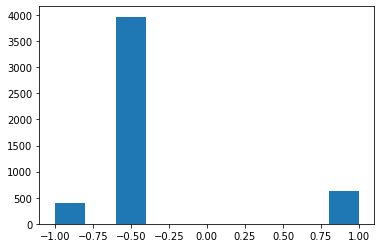

In [ ]:
plt.hist(preds[0].squeeze().cpu().numpy())

In [ ]:
preds[0].shape

torch.Size([5000, 1])

In [ ]:
preds[0][:40]

tensor([[-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [ 1.0000],
        [-1.0000],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915],
        [-0.0915]])

In [ ]:
544*520

282880

In [ ]:
540*523

282420